In [1]:
import numpy as np

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import matplotlib as matplotlib

#%matplotlib inline
#from matplotlib.patches import Ellipse

%matplotlib notebook
import math

import matplotlib.patches as mpatches

## splash particle simulation

series that only use one ejecta velocity 

Figures:
vesc_2D_a.png, vesc_2D_b.png, vesc_2D_Re.png, vesc_2D_ws.png, vesc_2D_thsw.png, vesc_2D_ws2.png,


In [2]:
# first create a particle uniformly distributed in unit circle (via impact parameter)
# returns a vector [x,y,z] on sphere
def create_pj():
    phi = np.random.uniform(low=0,high=2*np.pi)
    z  = np.random.uniform(low=0,high=1)
    x = np.sqrt(z)*np.cos(phi)  # sqrt makes distribution even on circle
    y = np.sqrt(z)*np.sin(phi)
    z = np.sqrt(1 - x**2 - y**2)
    r = np.array([x,y,z]) # returns a vector 
    return r  # impact point on sphere, units R_a=1 radius of planetesimal


In [3]:
# create a rotation matrix, rotates about axis, an angle theta in radians
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta in radians.
    https://en.wikipedia.org/wiki/Euler%E2%80%93Rodrigues_formula
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))  # normalize axis
    a = np.cos(theta/2.0)
    b, c, d = -axis * np.sin(theta/2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

# how to call this routine
# v = [3, 5, 0]
# axis = [4, 4, 1]
# theta = 1.2  (radians)
# do rotation 
#  rot_vec = np.dot(rotation_matrix(axis, theta), v)) 
# print(np.dot(rotation_matrix(axis, theta), v)) 

# compute a velocity direction for a splash particle 
# this creates a 45 degree from normal direction from x,y,z on sphere and downrange 
# inputs: 
#    r should be an array [x,y,z] and unit vector 
#    u is impact velocity direction (-zhat if coming from north pole)
# returns: unit vector in 45 degree direction from local normal and in plane 
#  spanned by impact velocity and local normal  
#  should be away from velocity direction -- in the downrange direction!
def create_splash_dir(r,u):
    rhat = np.copy(r)/np.sqrt(np.dot(r,r))
    uhat = np.copy(u)/np.sqrt(np.dot(u,u))
    dvec = uhat - np.dot(uhat,rhat)*rhat 
    dvec_mag = np.sqrt(np.dot(dvec,dvec))
    dvec_hat = dvec/dvec_mag  # this is down range vector!!!! 
    vhat2 = dvec_hat *np.cos(45*np.pi/180) + rhat*np.sin(45*np.pi/180)  # elevation of 45 degrees and downrange
    vm = np.sqrt(np.dot(vhat2,vhat2))
    vhat2 /= vm 
    #print(vhat2)
    
    if (1==0):  #checking previous calculation
        paxis = np.cross(r, uhat)  # r x u gives a vector perpendicular to both 
        paxis /= np.sqrt(np.dot(paxis,paxis))  #normalize, though not necessary
        rm = rotation_matrix(paxis, 45.*np.pi/180) # get rotation matrix 
        vhat = np.dot(rm,r)  # rotate r 
        vm = np.sqrt(np.dot(vhat,vhat))
        vhat /= vm
        #print(vhat) second calculation agrees with first 
    
    return np.array(vhat2)
    

testit =0
if (testit==1):
    # angle between zhat and vhat is always 45degrees 
    uhat = np.array([0.0,0.0,-1])
    umag = np.sqrt(np.dot(uhat,uhat))
    uhat/=umag
    r = create_pj(); #r = np.array([n,1,0])
    vhat=create_splash_dir(r,uhat); 
    print('r ',r)
    print('vhat ',vhat)
    ang = np.arccos(np.dot(r,vhat))*180/np.pi  #angle between normal and vhat should be 45 degrees , always true
    print(ang)
    ang2 = np.arccos(np.dot(uhat,vhat))*180/np.pi  # angle between velocity and ejecta 
    print(ang2)
    ang3 = np.arccos(np.dot(r,uhat))*180/np.pi  # angle between velocity and r
    print(ang3)
    
# checked!

In [4]:
# Create a random number with a power law distribution
# here returned quantity (velocity) is in range [a,b] with pdf(v) \propto v^beta
# negative powers are ok
# assumed units v/v_a v_a = np.sqrt(GM_a/R_a) gravitational 
def rndm(a, b, beta, size=1):
    # we want pdf(x) dx propto x^beta ;  this means that g-1 = beta
    # and g = beta+1
    g = beta+1.
    # Power-law gen for pdf(x)dx \propto x^{g-1} for a<=x<=b
    r = np.random.random(size=size)
    ag, bg = a**g, b**g
    return (ag + (bg - ag)*r)**(1./g)


# If we have rotation we need to add a surface rotation speed to our velocity velocity
# Here tilde_Omega_a_vec is a spin vector for the asteroid in units of Omega_a = sqrt(GM_a/R_a^3)
# r is in units of R_a, returned velocity in units of v_a
# returns Omega x r
# used in generating initial conditions for integrations 
def v_rotation(r,tilde_Omega_a_vec):
    v_rot = np.cross(tilde_Omega_a_vec,r) # tilde omega x r
    return np.array(v_rot)  # this is velocity vector of surface 

# checking sign
#r = np.array([1,0,0])
#om = np.array([0,0,1])  # z cross x = y 
#print(v_rotation(r,om))  #looks okay

In [5]:
# full routine to create a splash particle
# arguments:
#   tilde_uhw is headwind velocity in grav units 
#   vmax, vmax_vmin_ratio gives range of velocities for splashed particles [vmin,vmax]
#   assuming impact at tilde_uhw velocity 
#      with vmin = vmax/vmax_vmin_ratio 
#         vmax is equal to C_1 u_hw/v_a which sets max splash velocity in grav units for projectile at headwind vel
#   tilde_Omega_a_vec is spin vector of planetesimal in units of Omega_a = sqrt(GM_a/R_a^3)
# returns position vector and velocity vector of splash particle, gravitational units
# 
def create_splash(tilde_uhw,vmax,vmax_vmin_ratio,tilde_Omega_a_vec):
    r = create_pj()  # find initial impact point on upper hemisphere, r is a vector 
    # compute surface rotation vector 
    v_rot = v_rotation(r,tilde_Omega_a_vec)
    zhat = np.array([0,0,1])
    v_impact = -1*tilde_uhw*zhat  # impact velocity in inertial frame 
    v_impact_rf = v_impact - v_rot  # impact velocity in rotating frame 
    v_impact_rf_mag = np.sqrt(np.dot(v_impact_rf,v_impact_rf))
    v_impact_rf_hat = v_impact_rf/v_impact_rf_mag
    vhat = create_splash_dir(r,v_impact_rf_hat)  # get unit vector for splash particle direction 
        # in rotating frame 
    v_impact_ratio = v_impact_rf_mag/tilde_uhw  # would be 1 if no rotation 
    vmin_rf = vmax/vmax_vmin_ratio  * v_impact_ratio   # min ej velocity in rotating frame 
    vmax_rf = vmax*v_impact_ratio  # max ej velocity in rotating frame 
    mu = 0.4  # power from Housen and Holsapple 2011
    beta = -3.0*mu-1.0  # power for velocity distribution
    # get an ejecta velocity using power law distribution 
    vmag = rndm(vmin_rf, vmax_rf, beta, size=1)  # now we have a velocity magnitude, using power law distn
    vej = vmag*vhat  # create velocity vector of splash particle in rotating frame 
    vej += v_rot # rotate back into inertial frame 
    #print(r,vej)
    return r, vej  # return position and velocity of splashed particle in inertial frame 
    
# test it
testit=0
if (testit==1):
    # theta_s is angle from +z  in [0,180] take pi-theta_s if you want -z to be spin up
    theta_s_deg = 0  # in degrees 
    theta_s = theta_s_deg*np.pi/180.0   # in radians 
    tilde_Omega_a = 0.0 
    tilde_Omega_a_vec = np.array([np.sin(theta_s), 0.0, np.cos(theta_s)]) *tilde_Omega_a
    vmax = 0.1;  tilde_uhw=3
    vmax_vmin_ratio = 23.
    r,vej  = create_splash(tilde_uhw,vmax,vmax_vmin_ratio,tilde_Omega_a_vec); 
    print(r,vej)
    # seems okay!



In [6]:
# return velocity vector of wind, in units of v_a = sqrt(GM_a/R_a)
# arguments:
#    rvec position vector, not necessarily on sphere, could be above sphere 
#    tilde_uhw is equal to wind velocity at large radius in units of v_a
#    Re is Reynolds number of flow (about whole planetesimal) which is used in boundary layer
#    omega_vec is spin vector gravitational units
# returns: uvec, velocity vector of wind 
# we assume that wind comes from -z direction, potential flow model 
# BUT with a delta = sqrt(x/Re) Blasius boundary layer giving shear a velocity near surface, no slip
def u_wind_Bl(rvec,tilde_uhw,Re,omega_vec):
    x = rvec[0]; y = rvec[1]; z = rvec[2]
    rmag = np.sqrt(x**2 + y**2 + z**2)
    y_Bl = rmag - 1.0  # distance to surface 
    if (y_Bl <0):
        return 0.0  # cutoff no wind within surface 
    rhat = rvec/rmag
    vrot = v_rotation(rhat,omega_vec)  # rotation velocity of surface 
    fxy = 1.0  # goes from 0 to 1, 1 is at BL border
    # compute y_Bl, x_BL and fxy if whithin boundary layer
    if (Re>0):  # you can run without Boundary layer if you set Re negative or 0
        ctheta = z/rmag  # [-1,1] range
        x_Bl = np.arccos(ctheta)# distance along surface for Bl is always positive , range [0,pi] 
        delta_Bl = np.sqrt((x_Bl + 1e-6)/Re)   # boundary layer thickness, 1e-6 is a trap for x=0 problems
        if (y_Bl < delta_Bl):  # only correct flow within Boundary layer
            fxy = y_Bl/delta_Bl  # this goes from 0 to 1 in boundary layer
     
    # now compute potential flow model
    r3 = rmag**3
    r5 = rmag**5
    r2 = rmag**2
    z2 = z**2
    ux = 1.5*z*x/r5
    uy = 1.5*z*y/r5
    uz = -1 - (0.5/r3)*(1. - 3*z2/r2)
    uvec = np.array([ux,uy,uz])*tilde_uhw  # this is potential flow velocity  
    
    return uvec * fxy  + (1.0 - fxy) * vrot


In [7]:
# some routines for rotating arcs
# arguments:
#    r a position on surface of sphere (units R_a)
#    tilde_Omega_vec  a spin rotation vector  (units Omega_a)
#    Delta_t a  time (units Omega_a^-1)
# returns:
#    new r position after body has rotated 
def rotate_init_position(r,tilde_Omega_a_vec,Delta_t):
    spinval = np.sqrt(np.dot(tilde_Omega_a_vec,tilde_Omega_a_vec))
    spin_axis  = tilde_Omega_a_vec/spinval
    theta = spinval*Delta_t  # how far to rotate 
    rm = rotation_matrix(spin_axis, theta) # create rotation matrix
    new_r = np.dot(rm,r)  # rotate r vector 
    return new_r  # return rotated vector, sign of rotation has been checked 



In [8]:
# integrated splash particle one timestep of dt 
# arguments:
#  r is position vector (units R_a)
#  v is velocity vector (units v_a)
#  tilde_ts is stop time in gravitational units (units t_a= Omega_a^-1)
#  tilde_uhw is head wind velocity at infinity (units v_a)
#  Re reynolds number of whole flow
#  omega_vec is spin vector
#  dt step size units t_a 
# returns:
#   rnew, vnew:   new position and velocity after 1 timestep 
def do_integration_step_leapfrog(r,v,tilde_ts,tilde_uhw,Re,omega_vec,dt):
    rhalf = r + v*dt/2  #half drift step
    rmag = np.sqrt(np.dot(rhalf,rhalf))
    ac_grav = -rhalf/rmag**3   # acceleration from gravity force in gravity units
    uw = u_wind_Bl(rhalf,tilde_uhw,Re,omega_vec) # compute wind direction 
    ac_drag = (uw - v)/tilde_ts  # force in direction of wind, against motion, looks ok
    vnew = v + (ac_grav + ac_drag)*dt  # kick step
    rnew = rhalf + vnew*dt/2    # half drift step
    return rnew,vnew


# integrate splash particle until hits surface or escapes 
# arguments:
#  r_init is initial position vector (units R_a)
#  v_init is initial velocity vector (units v_a) in inertial frame 
#  tilde_ts is stop time in gravitational units (units t_a= Omega_a^-1)
#  tilde_uhw is head wind velocity at infinity (units v_a)
#  Re reynolds number of whole flow
#  omega_vec is spin vector
#  dt step size units t_a 
# returns: vectors of times, positions and velocities  
#   and a result which tells you what happened to the particle
def do_integration(r_init,v_init,tilde_ts,tilde_uhw,Re,omega_vec,dt):
    xarr = []; yarr = []; zarr = []
    vxarr = [];vyarr = [];vzarr = [];
    tarr = []
    r = r_init; v = v_init 
    x = r[0]; y = r[1]; z = r[2]
    vx = v[0]; vy = v[1]; vz = v[2]
    t = 0.0
    # store initial condition! 
    xarr = np.append(xarr,x); yarr = np.append(yarr,y); zarr = np.append(zarr,z)
    vxarr = np.append(vxarr,vx); vyarr = np.append(vyarr,vy); vzarr = np.append(vzarr,vz)
    tarr = np.append(tarr,t)
    fine = 1; #keep going until fine==0
    nsteps = 0 # keep track of how many steps we have done

    integration_result = -1 
    # is 0 if impacts surface at end
    # is 1 if particle escapes 
    # is 2 if integration took too long 
    while (fine==1):
        rnew,vnew = do_integration_step_leapfrog(r,v,tilde_ts,tilde_uhw,Re,omega_vec,dt) # take a step
        vmag = np.sqrt(np.dot(vnew,vnew))
        rmag = np.sqrt(np.dot(rnew,rnew))
        nsteps +=1
        if (vmag > 1.1* np.sqrt(2.) and (rmag>1.5)):
            fine=0  # well above escape velocity and away from planestimal so stop integration 
            integration_result = 1  
        if (rmag>2):  # trap for too far away
            fine=0;
            integration_result = 1  # escape
        if (rmag <0.999):
            fine=0  # below surface so stop integration 
            integration_result = 0    # impact 
        if (nsteps > 10000):  # trap for integration going on too long 
            fine=0
            integration_result = 2  
        if (fine>0): # we continue the integration 
            r = rnew
            v = vnew 
            x = r[0]; y = r[1]; z = r[2]
            vx = v[0]; vy = v[1]; vz = v[2]
            # store position and velocity 
            xarr = np.append(xarr,x); yarr = np.append(yarr,y); zarr = np.append(zarr,z)
            vxarr = np.append(vxarr,vx); vyarr = np.append(vyarr,vy); vzarr = np.append(vzarr,vz)
            t += dt
            tarr = np.append(tarr,t)
        
            
    return tarr,xarr,yarr,zarr,vxarr,vyarr,vzarr,integration_result




In [9]:

C_1 = 0.55  #crater scaling parm
mu = 0.4  # crater scaling exponent
G = 6.67430E-11 # N⋅m2⋅kg−2 grav constant mks
H_2 = 0.4 
n_1 = 1.2
pi_4 = 1.0
nu = 0.4

#rho_a = 1e3
#print('R_ratio ={:.2f}'.format(R_ratio))

# given planetesimal diameter in km and planetesimal density in kg m^-3
# get parameters needed in splash integrations 
def get_parms(D_a_km,rho_a,Y_a,u_hw):
    R_a = D_a_km*1e3/2  # Radius in m
    M_a = 4*np.pi*rho_a*R_a**3/3 # mass of planetesimal kg
    v_a = np.sqrt(G*M_a/R_a)  # velocity scale 
    Omega_a = v_a/R_a
    t_a = 1./Omega_a  # time unit
    tilde_uhw = u_hw/v_a     # wind velocity in grav units 
    pi_3 = Y_a/(rho_a*u_hw**2)
    R_ratio = (4.0*np.pi/3.)**0.33333 * H_2 * pi_3**(-mu/2) * pi_4**(-nu)
    vmax = tilde_uhw*C_1*pi_4**(-nu/mu)*n_1**(-1/mu)     # max velocity in grav units 
    vmin = tilde_uhw*C_1*pi_4**(-nu/mu)*R_ratio**(-1.0/mu) 
    vmax_vmin_ratio = vmax/vmin
    
    print('D_a_km={:.1f} km, v_a={:.1f} m/s, v_esc={:.1f}m/s, pi_3={:.1e}'.format(D_a_km,v_a,v_a*np.sqrt(2),pi_3))
    print('tilde_uhw={:.1f}, tilde_vmax={:.1f}, tilde_vmin={:.3f}, vmax_vmin_ratio={:.1f}'.format(\
                tilde_uhw,vmax,vmin,vmax_vmin_ratio))
    
    #print('D_a_km {:.0f}'.format(D_a_km))
    #print('pi_3 {:.1e}'.format(pi_3))
    #print('v_a {:.1f}'.format(v_a))
    #print('v_esc {:.1f}'.format(v_a*np.sqrt(2.)))  #escape vel in grav units
    #print('tilde_uhw {:.1f}'.format(tilde_uhw))
    #print('tilde vmax {:.1f}'.format(vmax))
    #print('vmax_vmin_ratio {:.1f}'.format(vmax_vmin_ratio))
    #print('tilde vmin {:.3f}'.format(vmin))   # minimum velocity in grav units 
    return tilde_uhw,vmax,vmax_vmin_ratio,v_a

 
# lets look at parameters for integrations 

u_hw = 47.0 # m/s  # setting by hand 
Y_a = 500.0
D_a_km = 10.
rho_a = 1000.
tilde_uhw_10,vmax_10,vmax_vmin_ratio_10,v_10 = get_parms(D_a_km,rho_a,Y_a,u_hw)

print("")
D_a_km = 31.
tilde_uhw_31,vmax_31,vmax_vmin_ratio_31,v_31 = get_parms(D_a_km,rho_a,Y_a,u_hw)

print("")
D_a_km = 100.
tilde_uhw_100,vmax_100,vmax_vmin_ratio_100,v_100 = get_parms(D_a_km,rho_a,Y_a,u_hw)

D_a_km=10.0 km, v_a=2.6 m/s, v_esc=3.7m/s, pi_3=2.3e-04
tilde_uhw=17.8, tilde_vmax=6.2, tilde_vmin=0.441, vmax_vmin_ratio=14.1

D_a_km=31.0 km, v_a=8.2 m/s, v_esc=11.6m/s, pi_3=2.3e-04
tilde_uhw=5.7, tilde_vmax=2.0, tilde_vmin=0.142, vmax_vmin_ratio=14.1

D_a_km=100.0 km, v_a=26.4 m/s, v_esc=37.4m/s, pi_3=2.3e-04
tilde_uhw=1.8, tilde_vmax=0.6, tilde_vmin=0.044, vmax_vmin_ratio=14.1


In [10]:
# given planetesimal mass in kg and planetesimal density in kg m^-3
# get parameters needed in splash integrations 
def get_parms_M(M_a,rho_a,Y_a,u_hw):
    R_a = ( (M_a/rho_a)*(3./(4*np.pi)) )**(1./3.) # Radius in m
    D_a_km = 2*R_a/1e3
    #R_a = D_a_km*1e3/2  
    #M_a = 4*np.pi*rho_a*R_a**3/3 # mass of planetesimal kg
    v_a = np.sqrt(G*M_a/R_a)  # velocity scale 
    Omega_a = v_a/R_a
    t_a = 1./Omega_a  # time unit
    tilde_uhw = u_hw/v_a     # wind velocity in grav units 
    
    pi_3 = Y_a/(rho_a*u_hw**2)
    R_ratio = (4.0*np.pi/3.)**0.33333 * H_2 * pi_3**(-mu/2) * pi_4**(-nu)
    vmax = tilde_uhw*C_1*pi_4**(-nu/mu)*n_1**(-1/mu)     # max velocity in grav units 
    vmin = tilde_uhw*C_1*pi_4**(-nu/mu)*R_ratio**(-1.0/mu) 
    vmax_vmin_ratio = vmax/vmin
    
    print('D_a_km={:.1f} km, v_a={:.1f} m/s, v_esc={:.1f}m/s, pi_3={:.1e}'.format(D_a_km,v_a,v_a*np.sqrt(2),pi_3))
    print('tilde_uhw={:.1f}, tilde_vmax={:.1f}, tilde_vmin={:.3f}, vmax_vmin_ratio={:.1f}'.format(\
                tilde_uhw,vmax,vmin,vmax_vmin_ratio))
    #print('pi_3 {:.1e}'.format(pi_3))
    #print('v_a {:.1f}'.format(v_a))
    #print('v_esc {:.1f}'.format(v_a*np.sqrt(2.)))  #escape vel in grav units
    
    #print('tilde vmax {:.1f}'.format(vmax))
    #print('vmax_vmin_ratio {:.1f}'.format(vmax_vmin_ratio))
    #print('tilde vmin {:.3f}'.format(vmin))   # minimum velocity in grav units 
    return tilde_uhw,vmax,vmax_vmin_ratio,v_a

print("")
M_a = 7.5e14 # kg  for Arrokoth
rho_a = 250.  #kg m-3
u_hw=47.  #m/s
Y_a=250  #Pa
tilde_uhw,vmax,vmax_vmin_ratio,v_a = get_parms_M(M_a,rho_a,Y_a,u_hw)


D_a_km=17.9 km, v_a=2.4 m/s, v_esc=3.3m/s, pi_3=4.5e-04
tilde_uhw=19.9, tilde_vmax=6.9, tilde_vmin=0.696, vmax_vmin_ratio=9.9


In [11]:

# let's get some statistics from integrations 
# nc is number of points
# return number of escape particles and angular distances travelled if no escape 
# more information returned
def stats2(nc,tilde_Omega_a_vec,vmax,vmax_vmin_ratio,tilde_ts,tilde_uhw,Re,dt):
    dtheta_arr = []
    theta_init_arr = []
    theta_final_arr = []
    nesc = 0
    for i in range(nc): # number of integrations 
        r_init,v_init  = create_splash(tilde_uhw,vmax,vmax_vmin_ratio,tilde_Omega_a_vec);  # get initial conditions 
        # do integration 
        tarr,xarr,yarr,zarr,vxarr,vyarr,vzarr,result=do_integration(r_init,v_init,tilde_ts,\
                                                tilde_uhw,Re,tilde_Omega_a_vec,dt)
        rmag = np.sqrt(np.dot(r_init,r_init))
        z = r_init[2]
        theta_init =np.arccos(z/rmag)
        theta_init_arr = np.append(theta_init_arr,theta_init)
        if (result ==1):  # escape particle 
            nesc += 1 
            theta_final_arr = np.append(theta_final_arr,-100)
            dtheta_arr = np.append(dtheta_arr,-100)
        else :
            r_final = np.array([xarr[-1],yarr[-1],zarr[-1]])
            r_final_mag = np.sqrt(np.dot(r_final,r_final))
            z_final = r_final[2]
            theta_final = np.arccos(z_final/r_final_mag)
            theta_final_arr = np.append(theta_final_arr,theta_final)
            r_final_hat = r_final/r_final_mag
            # find where particle would have been if just rotating with planetesimal
            tmax = tarr[-1]
            r_rot = rotate_init_position(r_init,tilde_Omega_a_vec,tmax) 
            r_rot_mag = np.sqrt(np.dot(r_rot,r_rot))
            r_rot /= r_rot_mag
            dtheta = np.arccos(np.dot(r_final_hat,r_rot)) # angle between rotated point and landing point 
            dtheta_arr = np.append(dtheta_arr,dtheta)
    return dtheta_arr, nesc,theta_init_arr,theta_final_arr

In [12]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

# make a cute color map for the mean dtheta figures 
#cmapB = mpl.colormaps['summer_r'].resampled(256)
cmapB = mpl.colormaps['brg'].resampled(256)
newcolors = cmapB(np.linspace(0, 1, 256))
pk = np.array([256/256, 256/256, 256/256, 1])
newcolors[0:1, :] = pk
newcmp = ListedColormap(newcolors)

In [13]:
# parameter sweep ts and uhw at Re = 1e6
ts_arr = np.logspace(-2,4.0,13)  # stopping times (dimensionless)
u_arr = np.logspace(-0.3,1.0,10)
print(u_arr,ts_arr)

Re = 1e6  # Reynold number of whole body
theta_s_deg = 45.  # in degrees 
theta_s = theta_s_deg*np.pi/180.0   # in radians 
tilde_Omega_a = 0.001
tilde_Omega_a_vec = np.array([np.sin(theta_s), 0.0, np.cos(theta_s)]) *tilde_Omega_a
dt = 0.005  # timestep
nc = 100   # number of particles integrated 

vmax_fac =C_1*1.2**(-1/mu)
vmax_vmin_ratio = 1.0001

ts_2D,u_2D = np.meshgrid(ts_arr,u_arr)  # X,Y
lt_a = np.log10(ts_2D)
lu_a = np.log10(u_2D)
nesc_2D_a = u_2D*0.0
mean_dt_a = u_2D*0.0
for j in range(len(ts_arr)):
    print(j)
    for i in range(len(u_arr)):
        tilde_uhw = u_2D[i,j]
        tilde_ts = ts_2D[i,j]
        print('ts,tuhw',tilde_ts,tilde_uhw)
        vmax = vmax_fac*tilde_uhw
        
        dtheta_arr, nesc,theta_init_arr,theta_final_arr = \
            stats2(nc,tilde_Omega_a_vec,vmax,vmax_vmin_ratio,tilde_ts,tilde_uhw,Re,dt)
        nesc_2D_a[i,j] = nesc/nc
        kk = (dtheta_arr >= 0)  # is Boolean
        nk = len(dtheta_arr[kk])
        if (nk>1):
            mean_dt_a[i,j] = np.mean(dtheta_arr[kk])
        else:
            mean_dt_a[i,j] = -100  # false value here
    
# takes a while

[ 0.50118723  0.69894732  0.97474023  1.35935639  1.89573565  2.64376119
  3.68694506  5.14175183  7.17060097 10.        ] [1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00 3.16227766e+00 1.00000000e+01 3.16227766e+01
 1.00000000e+02 3.16227766e+02 1.00000000e+03 3.16227766e+03
 1.00000000e+04]
0
ts,tuhw 0.01 0.5011872336272722
ts,tuhw 0.01 0.6989473207273486
ts,tuhw 0.01 0.9747402255566063
ts,tuhw 0.01 1.3593563908785258
ts,tuhw 0.01 1.8957356524063762
ts,tuhw 0.01 2.6437611857491
ts,tuhw 0.01 3.686945064519575
ts,tuhw 0.01 5.141751827683928
ts,tuhw 0.01 7.1706009704096125
ts,tuhw 0.01 10.0
1
ts,tuhw 0.03162277660168379 0.5011872336272722
ts,tuhw 0.03162277660168379 0.6989473207273486
ts,tuhw 0.03162277660168379 0.9747402255566063
ts,tuhw 0.03162277660168379 1.3593563908785258
ts,tuhw 0.03162277660168379 1.8957356524063762
ts,tuhw 0.03162277660168379 2.6437611857491
ts,tuhw 0.03162277660168379 3.686945064519575
ts,tuhw 0.03162277660168379 5.141751827683928
t

<IPython.core.display.Javascript object>


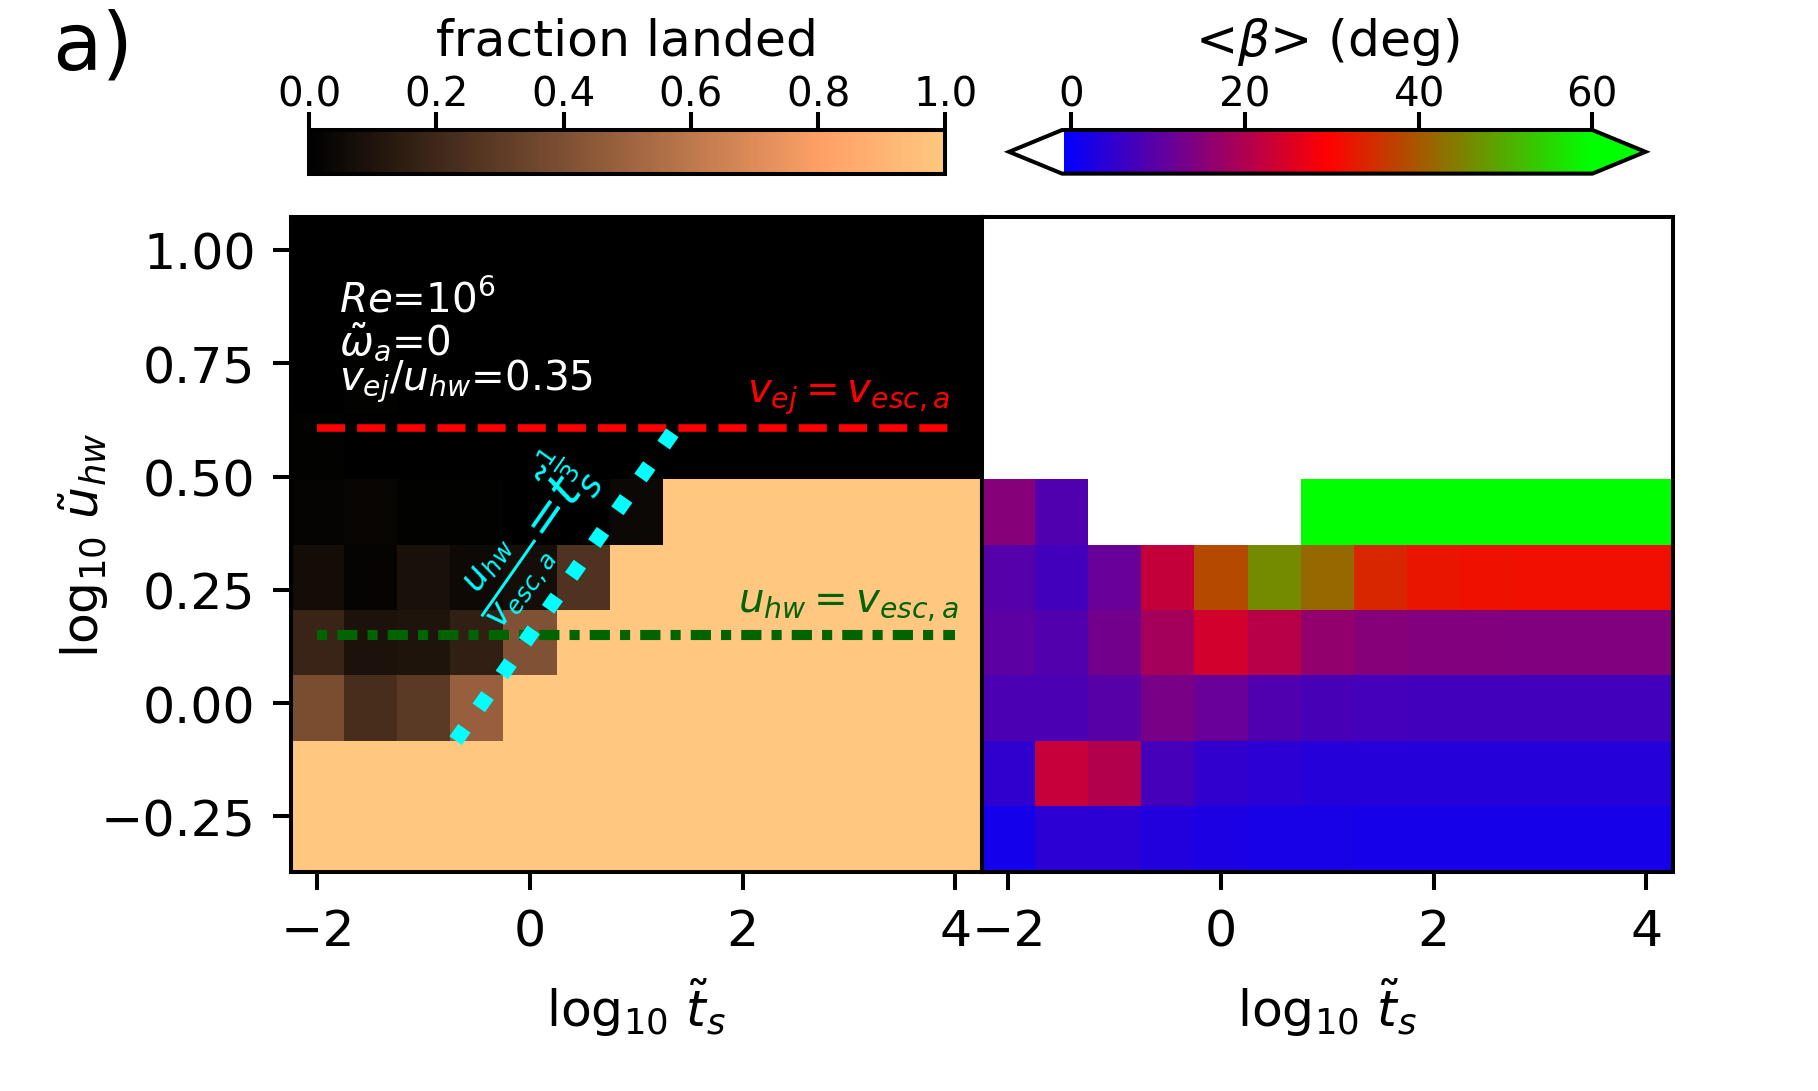

[-0.08281834  0.03384833  0.150515    0.26718166  0.38384833  0.500515
  0.61718166]


In [16]:
fig,axarr = plt.subplots(1,2,figsize=(5,3),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.16,right=0.92,top=0.80,bottom=0.2,hspace=0,wspace=0)
axarr[0].set_xlabel(r'log$_{10}$ $\tilde t_s$')
axarr[0].set_ylabel(r'log$_{10}$ $\tilde u_{hw}$',labelpad=-2)
axarr[1].set_xlabel(r'log$_{10}$ $\tilde t_s$')
axarr[1].set_yticks([])
cax1 = plt.axes((0.17, 0.84, 0.35, 0.04))
cax1.tick_params(labelsize=8,pad=-0.5)
cax2 = plt.axes((0.555, 0.84, 0.35, 0.04))
cax2.tick_params(labelsize=8,pad=-0.5)

im=axarr[0].pcolormesh(lt_a, lu_a,1-nesc_2D_a,shading='auto',cmap='copper',vmin=0,vmax=1)
cbar = plt.colorbar(im,cax = cax1, location='top')
cbar.set_label(label='fraction landed',size=10)
im2=axarr[1].pcolormesh(lt_a, lu_a,mean_dt_a*180/np.pi,shading='auto',cmap=newcmp,vmin=-1,vmax=60) # ,vmin=0,vmax=1)
cbar2=plt.colorbar(im2,extend='both',extendfrac=0.1,cax = cax2, location='top')
cbar2.set_label(label=r'<$\beta$> (deg)',size=10)

xll = -1.8
dz = 0.09; y0=0.8
lcolor='white'
axarr[0].text(xll,y0, r'$\tilde \omega_a$=0',va='center',ha='left',fontsize=8,color=lcolor)
axarr[0].text(xll,y0+dz*1, r'$Re$=$10^6$',va='center',ha='left',fontsize=8,color=lcolor)
vstr = r'$v_{ej}/u_{hw}$=' + '{:.2f}'.format(vmax_fac)
axarr[0].text(xll,y0-dz*1,vstr,va='center',ha='left',fontsize=8,color=lcolor)

lvhoriz = np.log10(np.sqrt(2.)/vmax_fac)  # vmax_fac should be 0.35
axarr[0].plot([-2,4],[lvhoriz,lvhoriz],'r--')
axarr[0].text(3,lvhoriz+0.07,r'$v_{ej} = v_{esc,a}$',color='red',ha='center',va='center',fontsize=8)

lvhoriz2 = np.log10(np.sqrt(2.))  # u_hw = v_esc
axarr[0].plot([-2,4],[lvhoriz2,lvhoriz2],ls = (0,(1,1,2,1)),lw=2,color='darkgreen')
axarr[0].text(3,lvhoriz2+0.07,r'$u_{hw} = v_{esc,a}$',color='darkgreen',ha='center',va='center',fontsize=8)

tlin = np.linspace(-0.7,1.4,7)  # log ts 
ts = 10**tlin
u_lin = ts**(1.0/3.0)   *np.sqrt(2.0)  # this is u/vesc,a =   ts^1/3
lu_lin = np.log10(u_lin)
print(lu_lin)
axarr[0].plot(tlin,lu_lin,':',color='cyan',lw=3)
axarr[0].text(-0.84,0.2,r'$\frac{u_{hw}}{v_{esc,a}}$=$ \tilde t_s^\frac{1}{3}$',color='cyan',rotation=55)

axarr[0].text(-4.5,1.4,'a)',fontsize=16)
plt.savefig('vesc_2D_a.png',dpi=200)

In [17]:
# parameter sweep ts and uwind but at Re=100
ts_arr = np.logspace(-2,4.0,13)  # stopping times (dimensionless)
u_arr = np.logspace(-0.3,1.0,10)
print(u_arr,ts_arr)

Re = 100  # Reynold number of whole body
theta_s_deg = 45.  # in degrees 
theta_s = theta_s_deg*np.pi/180.0   # in radians 
tilde_Omega_a = 0.001
tilde_Omega_a_vec = np.array([np.sin(theta_s), 0.0, np.cos(theta_s)]) *tilde_Omega_a
dt = 0.005  # timestep
nc = 100   # number of particles integrated 

vmax_fac =C_1*1.2**(-1/mu)
vmax_vmin_ratio = 1.0001

ts_2D,u_2D = np.meshgrid(ts_arr,u_arr)  # X,Y
lt_b = np.log10(ts_2D)
lu_b = np.log10(u_2D)
nesc_2D_b = u_2D*0.0
mean_dt_b = u_2D*0.0
for j in range(len(ts_arr)):
    print(j)
    for i in range(len(u_arr)):
        tilde_uhw = u_2D[i,j]
        tilde_ts = ts_2D[i,j]
        print('ts,tuhw',tilde_ts,tilde_uhw)
        vmax = vmax_fac*tilde_uhw
        
        dtheta_arr, nesc,theta_init_arr,theta_final_arr = \
            stats2(nc,tilde_Omega_a_vec,vmax,vmax_vmin_ratio,tilde_ts,tilde_uhw,Re,dt)
        nesc_2D_b[i,j] = nesc/nc
        kk = (dtheta_arr >= 0)  # is Boolean
        nk = len(dtheta_arr[kk])
        if (nk>1):
            mean_dt_b[i,j] = np.mean(dtheta_arr[kk])
        else:
            mean_dt_b[i,j] = -100  # false value here
        
        

[ 0.50118723  0.69894732  0.97474023  1.35935639  1.89573565  2.64376119
  3.68694506  5.14175183  7.17060097 10.        ] [1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00 3.16227766e+00 1.00000000e+01 3.16227766e+01
 1.00000000e+02 3.16227766e+02 1.00000000e+03 3.16227766e+03
 1.00000000e+04]
0
ts,tuhw 0.01 0.5011872336272722
ts,tuhw 0.01 0.6989473207273486
ts,tuhw 0.01 0.9747402255566063
ts,tuhw 0.01 1.3593563908785258
ts,tuhw 0.01 1.8957356524063762
ts,tuhw 0.01 2.6437611857491
ts,tuhw 0.01 3.686945064519575
ts,tuhw 0.01 5.141751827683928
ts,tuhw 0.01 7.1706009704096125
ts,tuhw 0.01 10.0
1
ts,tuhw 0.03162277660168379 0.5011872336272722
ts,tuhw 0.03162277660168379 0.6989473207273486
ts,tuhw 0.03162277660168379 0.9747402255566063
ts,tuhw 0.03162277660168379 1.3593563908785258
ts,tuhw 0.03162277660168379 1.8957356524063762
ts,tuhw 0.03162277660168379 2.6437611857491
ts,tuhw 0.03162277660168379 3.686945064519575
ts,tuhw 0.03162277660168379 5.141751827683928
t

<IPython.core.display.Javascript object>


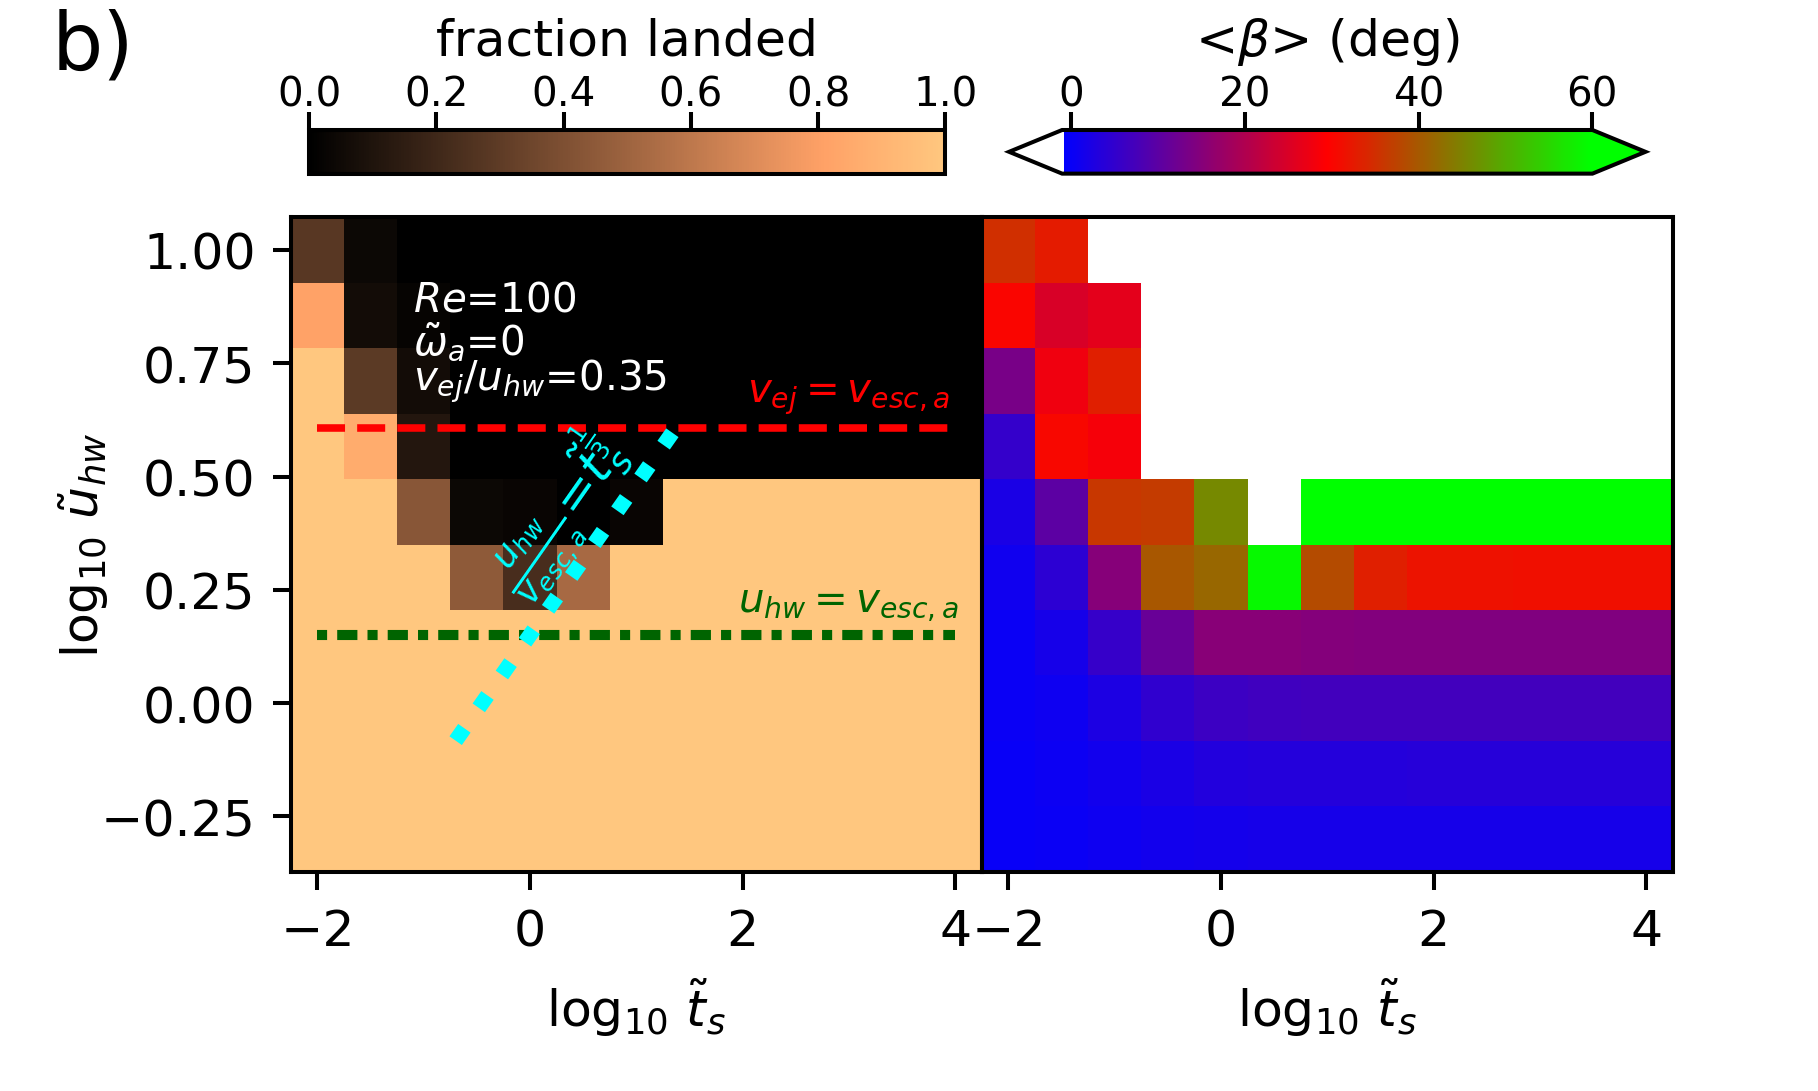

[-0.08281834  0.03384833  0.150515    0.26718166  0.38384833  0.500515
  0.61718166]


In [18]:
fig,axarr = plt.subplots(1,2,figsize=(5,3),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.16,right=0.92,top=0.80,bottom=0.2,hspace=0,wspace=0)
axarr[0].set_xlabel(r'log$_{10}$ $\tilde t_s$')
axarr[0].set_ylabel(r'log$_{10}$ $\tilde u_{hw}$',labelpad=-2)
axarr[1].set_xlabel(r'log$_{10}$ $\tilde t_s$')
axarr[1].set_yticks([])
cax1 = plt.axes((0.17, 0.84, 0.35, 0.04))
cax1.tick_params(labelsize=8,pad=-0.5)
cax2 = plt.axes((0.555, 0.84, 0.35, 0.04))
cax2.tick_params(labelsize=8,pad=-0.5)

im=axarr[0].pcolormesh(lt_b, lu_b,1-nesc_2D_b,shading='auto',cmap='copper',vmin=0,vmax=1)
cbar = plt.colorbar(im,cax = cax1, location='top')
cbar.set_label(label='fraction landed',size=10)
im2=axarr[1].pcolormesh(lt_b, lu_b,mean_dt_b*180/np.pi,shading='auto',cmap=newcmp,vmin=-1,vmax=60) # ,vmin=0,vmax=1)
cbar2=plt.colorbar(im2,extend='both',extendfrac=0.1,cax = cax2, location='top')
cbar2.set_label(label=r'<$\beta$> (deg)',size=10)

xll = -1.1
dz = 0.09; y0=0.8
lcolor='white'
axarr[0].text(xll,y0, r'$\tilde \omega_a$=0',va='center',ha='left',fontsize=8,color=lcolor)
axarr[0].text(xll,y0+dz*1, r'$Re$=100',va='center',ha='left',fontsize=8,color=lcolor)
vstr = r'$v_{ej}/u_{hw}$=' + '{:.2f}'.format(vmax_fac)
axarr[0].text(xll,y0-dz*1,vstr,va='center',ha='left',fontsize=8,color=lcolor)

lvhoriz = np.log10(np.sqrt(2.)/vmax_fac )
axarr[0].plot([-2,4],[lvhoriz,lvhoriz],'r--')
axarr[0].text(3,lvhoriz+0.07,r'$v_{ej} = v_{esc,a}$',color='red',ha='center',va='center',fontsize=8)

lvhoriz2 = np.log10(np.sqrt(2.))  # u_hw = v_esc
axarr[0].plot([-2,4],[lvhoriz2,lvhoriz2],ls = (0,(1,1,2,1)),lw=2,color='darkgreen')
axarr[0].text(3,lvhoriz2+0.07,r'$u_{hw} = v_{esc,a}$',color='darkgreen',ha='center',va='center',fontsize=8)

tlin = np.linspace(-0.7,1.4,7)  # log ts 
ts = 10**tlin
u_lin = ts**(1.0/3.0)* np.sqrt(2.)  # is u/vesc_a = t^1/3
lu_lin = np.log10(u_lin)
print(lu_lin)
axarr[0].plot(tlin,lu_lin,':',color='cyan',lw=3)
axarr[0].text(-0.55,0.25,r'$\frac{u_{hw}}{v_{esc,a}}$=$ \tilde t_s^\frac{1}{3}$',color='cyan',rotation=55)

axarr[0].text(-4.5,1.4,'b)',fontsize=16)
plt.savefig('vesc_2D_b.png',dpi=200)


In [157]:
# parameter sweep ts and Re 
ts_arr = np.logspace(-2,4.0,13)  # stopping times (dimensionless)
Re_arr = np.logspace(1,5,8)
print(Re_arr,ts_arr)

theta_s_deg = 45.  # in degrees 
theta_s = theta_s_deg*np.pi/180.0   # in radians 
tilde_Omega_a = 0.001
tilde_Omega_a_vec = np.array([np.sin(theta_s), 0.0, np.cos(theta_s)]) *tilde_Omega_a
dt = 0.005  # timestep
nc = 100   # number of particles integrated 
tilde_uhw = 3.0  # hardset

vmax_fac =C_1*1.2**(-1/mu)
vmax_vmin_ratio = 1.0001

ts_2D,Re_2D = np.meshgrid(ts_arr,Re_arr)  # X,Y
lt_g = np.log10(ts_2D)
lR_g = np.log10(Re_2D)
nesc_2D_g = Re_2D*0.0
mean_dt_g = Re_2D*0.0
for j in range(len(ts_arr)):
    print(j)
    for i in range(len(Re_arr)):
        Re = Re_2D[i,j]
        tilde_ts = ts_2D[i,j]
        print('ts,Re',tilde_ts,Re)
        vmax = vmax_fac*tilde_uhw
        
        dtheta_arr, nesc,theta_init_arr,theta_final_arr = \
            stats2(nc,tilde_Omega_a_vec,vmax,vmax_vmin_ratio,tilde_ts,tilde_uhw,Re,dt)
        nesc_2D_g[i,j] = nesc/nc
        kk = (dtheta_arr >= 0)  # is Boolean
        nk = len(dtheta_arr[kk])
        if (nk>1):
            mean_dt_g[i,j] = np.mean(dtheta_arr[kk])
        else:
            mean_dt_g[i,j] = -100  # false value here
        

[1.00000000e+01 3.72759372e+01 1.38949549e+02 5.17947468e+02
 1.93069773e+03 7.19685673e+03 2.68269580e+04 1.00000000e+05] [1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00 3.16227766e+00 1.00000000e+01 3.16227766e+01
 1.00000000e+02 3.16227766e+02 1.00000000e+03 3.16227766e+03
 1.00000000e+04]
0
ts,Re 0.01 10.0
ts,Re 0.01 37.2759372031494
ts,Re 0.01 138.94954943731375
ts,Re 0.01 517.9474679231213
ts,Re 0.01 1930.6977288832495
ts,Re 0.01 7196.856730011514
ts,Re 0.01 26826.957952797275
ts,Re 0.01 100000.0
1
ts,Re 0.03162277660168379 10.0
ts,Re 0.03162277660168379 37.2759372031494
ts,Re 0.03162277660168379 138.94954943731375
ts,Re 0.03162277660168379 517.9474679231213
ts,Re 0.03162277660168379 1930.6977288832495
ts,Re 0.03162277660168379 7196.856730011514
ts,Re 0.03162277660168379 26826.957952797275
ts,Re 0.03162277660168379 100000.0
2
ts,Re 0.1 10.0
ts,Re 0.1 37.2759372031494
ts,Re 0.1 138.94954943731375
ts,Re 0.1 517.9474679231213
ts,Re 0.1 1930.6977288832495

<IPython.core.display.Javascript object>


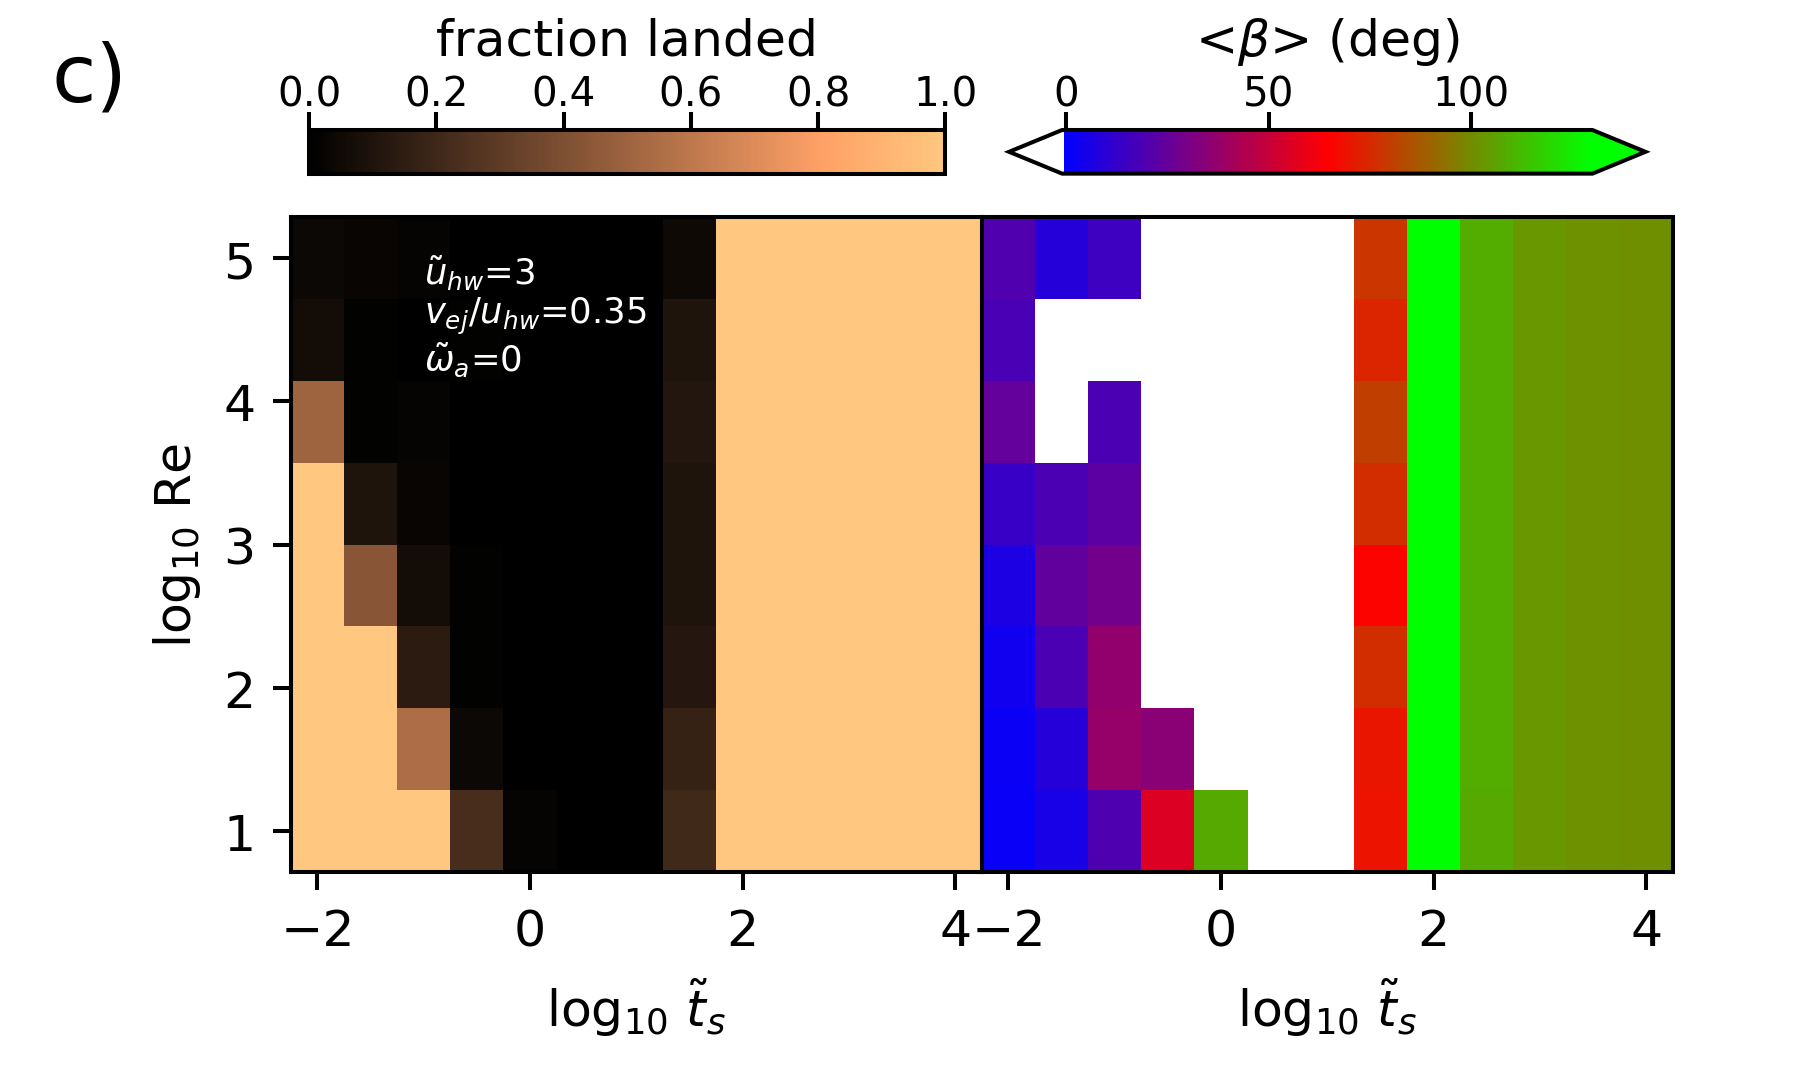

In [252]:
fig,axarr = plt.subplots(1,2,figsize=(5,3),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.16,right=0.92,top=0.80,bottom=0.2,hspace=0,wspace=0)
axarr[0].set_xlabel(r'log$_{10}$ $\tilde t_s$')
axarr[1].set_xlabel(r'log$_{10}$ $\tilde t_s$')
axarr[0].set_ylabel(r'log$_{10}$ Re')
axarr[1].set_yticks([])
cax1 = plt.axes((0.17, 0.84, 0.35, 0.04))
cax1.tick_params(labelsize=8,pad=-0.5)
cax2 = plt.axes((0.555, 0.84, 0.35, 0.04))
cax2.tick_params(labelsize=8,pad=-0.5)

im=axarr[0].pcolormesh(lt_g, lR_g,1-nesc_2D_g,shading='auto',cmap='copper',vmin=0,vmax=1)
cbar = plt.colorbar(im,cax = cax1, location='top')
cbar.set_label(label='fraction landed',size=10)

im2=axarr[1].pcolormesh(lt_g, lR_g,mean_dt_g*180/np.pi,shading='auto',cmap=newcmp,vmin=-1,vmax=130) 
cbar2=plt.colorbar(im2,extend='both',extendfrac=0.1,cax = cax2, location='top')
cbar2.set_label(label=r'<$\beta$> (deg)',size=10)

xll = -1
dz = 0.3; y0=4.3
lcolor='white'
axarr[0].text(xll,y0, r'$\tilde \omega_{a}$=0',va='center',ha='left',fontsize=7,color=lcolor)
#axarr[0].text(xll,y0+dz*1, r'$Re$=100',va='center',ha='left',fontsize=7,color=lcolor)
axarr[0].text(xll,y0+dz*1, r'$v_{ej}/u_{hw}$=0.35',va='center',ha='left',fontsize=7,color=lcolor)
axarr[0].text(xll,y0+dz*2, r'$\tilde u_{hw}$=3',va='center',ha='left',fontsize=7,color=lcolor)


axarr[0].text(-4.5,6.1,'c)',fontsize=16)
plt.savefig('vesc_2D_Re.png',dpi=200)


In [ ]:
# second set of integrations!!!

In [347]:
#parameter sweep ts and spin omega
ts_arr = np.logspace(-2,4.0,13)  # stopping times (dimensionless)
om_arr = np.linspace(0.2,1.02,10)
print(om_arr,ts_arr)

Re = 100  # Reynold number of whole body
theta_s_deg = 45.  # in degrees 
theta_s = theta_s_deg*np.pi/180.0   # in radians 

dt = 0.005  # timestep
nc = 100   # number of particles integrated 

vmax_fac =C_1*1.2**(-1/mu)
vmax_vmin_ratio = 1.0001
tilde_uhw = 3.0  # hardset

ts_2D,om_2D_c = np.meshgrid(ts_arr,om_arr)  # X,Y
lt_c = np.log10(ts_2D)
#lu_b = np.log10(om_2D)
nesc_2D_c = om_2D_c*0.0
mean_dt_c = om_2D_c*0.0
for j in range(len(ts_arr)):
    print(j)
    for i in range(len(om_arr)):
        tilde_Omega_a = om_2D_c[i,j]
        tilde_ts = ts_2D[i,j]
        print('ts,Om',tilde_ts,tilde_Omega_a)
        tilde_Omega_a_vec = np.array([np.sin(theta_s), 0.0, np.cos(theta_s)]) *tilde_Omega_a
        vmax = vmax_fac*tilde_uhw
        dtheta_arr, nesc,theta_init_arr,theta_final_arr = \
            stats2(nc,tilde_Omega_a_vec,vmax,vmax_vmin_ratio,tilde_ts,tilde_uhw,Re,dt)
        nesc_2D_c[i,j] = nesc/nc
        kk = (dtheta_arr >= 0)  # is Boolean
        nk = len(dtheta_arr[kk])
        if (nk>1):
            mean_dt_c[i,j] = np.mean(dtheta_arr[kk])
        else:
            mean_dt_c[i,j] = -100  # false value here

[0.2        0.29111111 0.38222222 0.47333333 0.56444444 0.65555556
 0.74666667 0.83777778 0.92888889 1.02      ] [1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00 3.16227766e+00 1.00000000e+01 3.16227766e+01
 1.00000000e+02 3.16227766e+02 1.00000000e+03 3.16227766e+03
 1.00000000e+04]
0
ts,Om 0.01 0.2
ts,Om 0.01 0.2911111111111111
ts,Om 0.01 0.38222222222222224
ts,Om 0.01 0.47333333333333333
ts,Om 0.01 0.5644444444444445
ts,Om 0.01 0.6555555555555557
ts,Om 0.01 0.7466666666666666
ts,Om 0.01 0.8377777777777777
ts,Om 0.01 0.9288888888888889
ts,Om 0.01 1.02
1
ts,Om 0.03162277660168379 0.2
ts,Om 0.03162277660168379 0.2911111111111111
ts,Om 0.03162277660168379 0.38222222222222224
ts,Om 0.03162277660168379 0.47333333333333333
ts,Om 0.03162277660168379 0.5644444444444445
ts,Om 0.03162277660168379 0.6555555555555557
ts,Om 0.03162277660168379 0.7466666666666666
ts,Om 0.03162277660168379 0.8377777777777777
ts,Om 0.03162277660168379 0.9288888888888889
ts,Om 0.0316227766

<IPython.core.display.Javascript object>


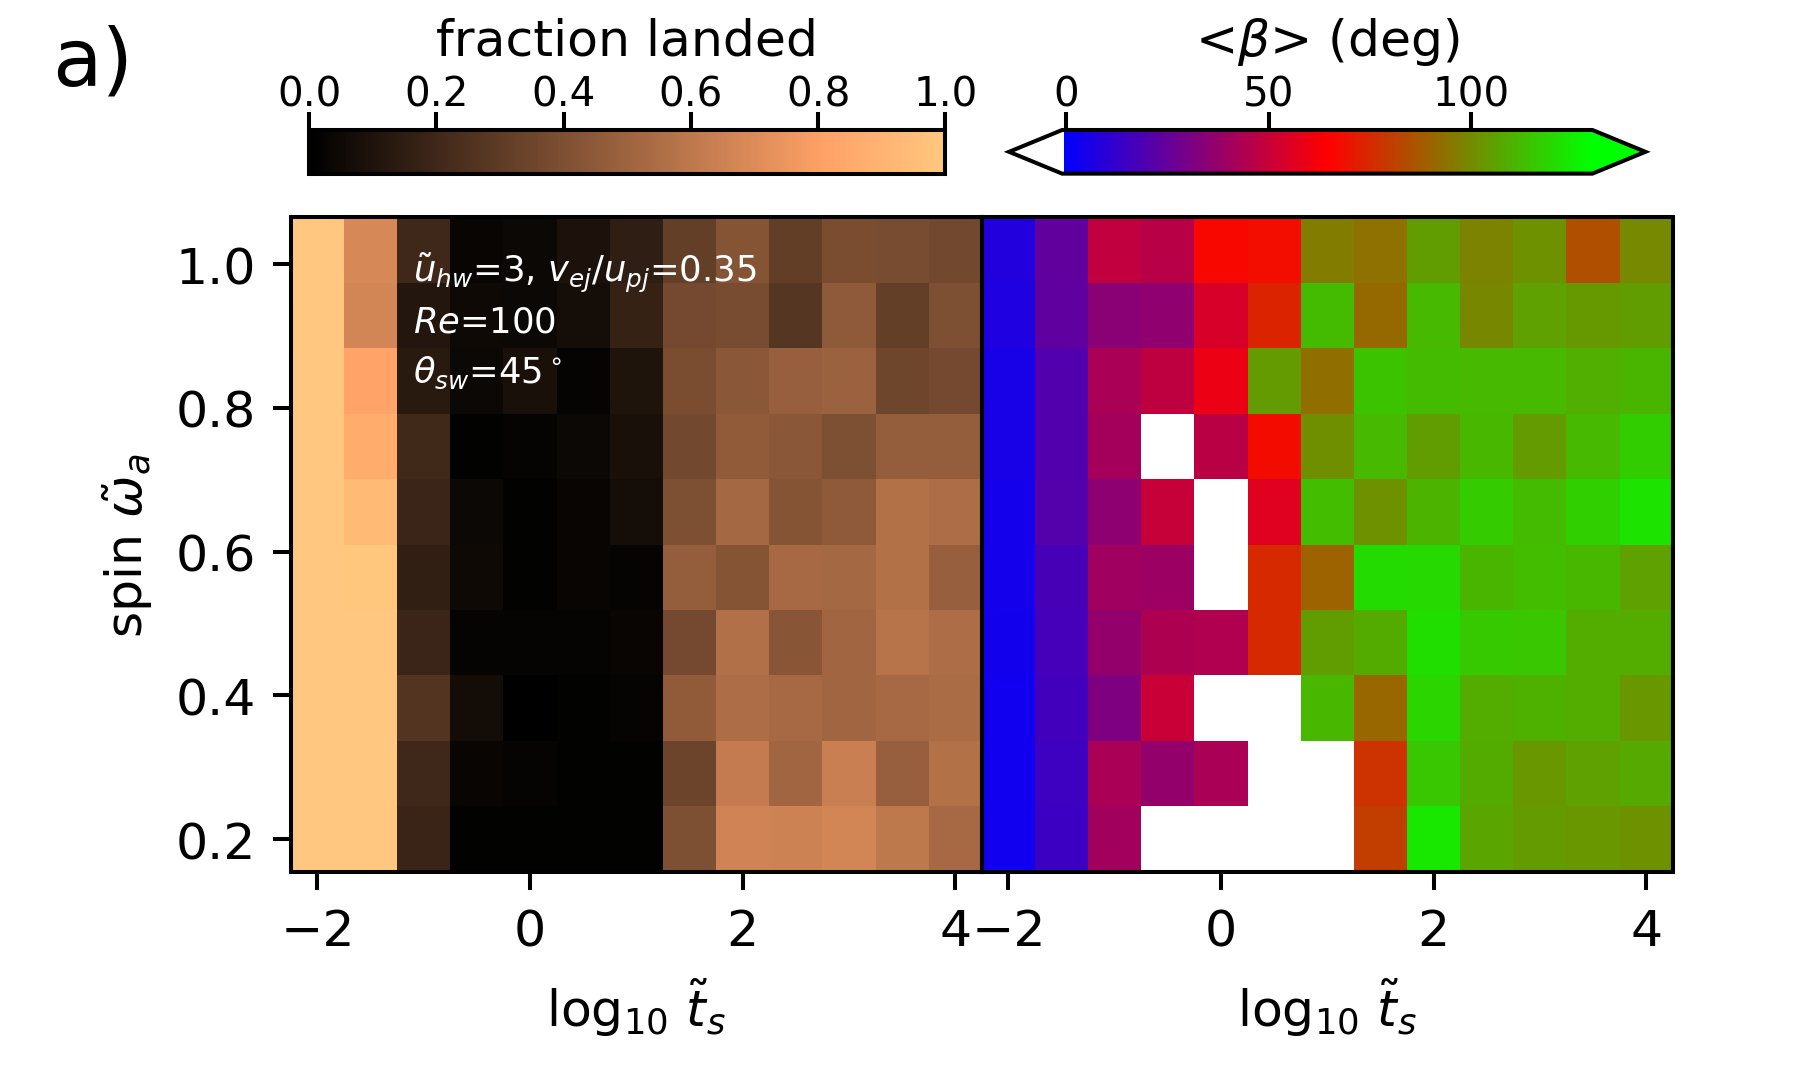

In [357]:
fig,axarr = plt.subplots(1,2,figsize=(5,3),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.16,right=0.92,top=0.80,bottom=0.2,hspace=0,wspace=0)
axarr[0].set_xlabel(r'log$_{10}$ $\tilde t_s$')
axarr[1].set_xlabel(r'log$_{10}$ $\tilde t_s$')
axarr[0].set_ylabel(r'spin $\tilde \omega_a$',labelpad=4)
axarr[1].set_yticks([])
cax1 = plt.axes((0.17, 0.84, 0.35, 0.04))
cax1.tick_params(labelsize=8,pad=-0.5)
cax2 = plt.axes((0.555, 0.84, 0.35, 0.04))
cax2.tick_params(labelsize=8,pad=-0.5)

im=axarr[0].pcolormesh(lt_c, om_2D_c,1-nesc_2D_c,shading='auto',cmap='copper',vmin=0,vmax=1)
cbar = plt.colorbar(im,cax = cax1, location='top')
cbar.set_label(label='fraction landed',size=10)
im2=axarr[1].pcolormesh(lt_c, om_2D_c,mean_dt_c*180/np.pi,shading='auto',cmap=newcmp,vmin=-1,vmax=130) # ,vmin=0,vmax=1)
cbar2=plt.colorbar(im2,extend='both',extendfrac=0.1,cax = cax2, location='top')
cbar2.set_label(label=r'<$\beta$> (deg)',size=10)

xll = -1.1
dz = 0.07; y0=0.85
lcolor='white'
axarr[0].text(xll,y0, r'$\theta_{sw}$=$45^\circ$',va='center',ha='left',fontsize=7,color=lcolor)
axarr[0].text(xll,y0+dz*1, r'$Re$=100',va='center',ha='left',fontsize=7,color=lcolor)
axarr[0].text(xll,y0+dz*2, r'$\tilde u_{hw}$=3, $v_{ej}/u_{pj}$=0.35',va='center',ha='left',fontsize=7,color=lcolor)

axarr[0].text(-4.5,1.25,'a)',fontsize=16)
plt.savefig('vesc_2D_ws.png',dpi=200)


In [341]:
#parameter sweep ts and spin angle 
ts_arr = np.logspace(-2,4.0,13)  # stopping times (dimensionless)
theta_arr = np.linspace(0.0,np.pi,9)
print(theta_arr,ts_arr)

Re = 100  # Reynold number of whole body
#theta_s_deg = 45.  # in degrees   not used in this section
#theta_s = theta_s_deg*np.pi/180.0   # in radians 

dt = 0.005  # timestep
nc = 100   # number of particles integrated 
tilde_Omega_a=0.7  # hard set spin here!!!!!

vmax_fac =C_1*1.2**(-1/mu)
vmax_vmin_ratio = 1.0001
tilde_uhw = 3  # hardset

ts_2D,theta_2D = np.meshgrid(ts_arr,theta_arr)  # X,Y
lt_e = np.log10(ts_2D)
#lu_b = np.log10(om_2D)
nesc_2D_e = theta_2D*0.0
mean_dt_e = theta_2D*0.0
theta_2D_e = theta_2D
for j in range(len(ts_arr)):
    print(j)
    for i in range(len(theta_arr)):
        theta_s = theta_2D[i,j]
        tilde_ts = ts_2D[i,j]
        print('ts,theta_s',tilde_ts,theta_s)
        tilde_Omega_a_vec = np.array([np.sin(theta_s), 0.0, np.cos(theta_s)]) *tilde_Omega_a
        vmax = vmax_fac*tilde_uhw
        dtheta_arr, nesc,theta_init_arr,theta_final_arr = \
            stats2(nc,tilde_Omega_a_vec,vmax,vmax_vmin_ratio,tilde_ts,tilde_uhw,Re,dt)
        nesc_2D_e[i,j] = nesc/nc
        kk = (dtheta_arr >= 0)  # is Boolean
        nk = len(dtheta_arr[kk])
        if (nk>1):
            mean_dt_e[i,j] = np.mean(dtheta_arr[kk])
        else:
            mean_dt_e[i,j] = -100  # false value here

[0.         0.39269908 0.78539816 1.17809725 1.57079633 1.96349541
 2.35619449 2.74889357 3.14159265] [1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00 3.16227766e+00 1.00000000e+01 3.16227766e+01
 1.00000000e+02 3.16227766e+02 1.00000000e+03 3.16227766e+03
 1.00000000e+04]
0
ts,theta_s 0.01 0.0
ts,theta_s 0.01 0.39269908169872414
ts,theta_s 0.01 0.7853981633974483
ts,theta_s 0.01 1.1780972450961724
ts,theta_s 0.01 1.5707963267948966
ts,theta_s 0.01 1.9634954084936207
ts,theta_s 0.01 2.356194490192345
ts,theta_s 0.01 2.748893571891069
ts,theta_s 0.01 3.141592653589793
1
ts,theta_s 0.03162277660168379 0.0
ts,theta_s 0.03162277660168379 0.39269908169872414
ts,theta_s 0.03162277660168379 0.7853981633974483
ts,theta_s 0.03162277660168379 1.1780972450961724
ts,theta_s 0.03162277660168379 1.5707963267948966
ts,theta_s 0.03162277660168379 1.9634954084936207
ts,theta_s 0.03162277660168379 2.356194490192345
ts,theta_s 0.03162277660168379 2.748893571891069
ts,theta_s 0

<IPython.core.display.Javascript object>


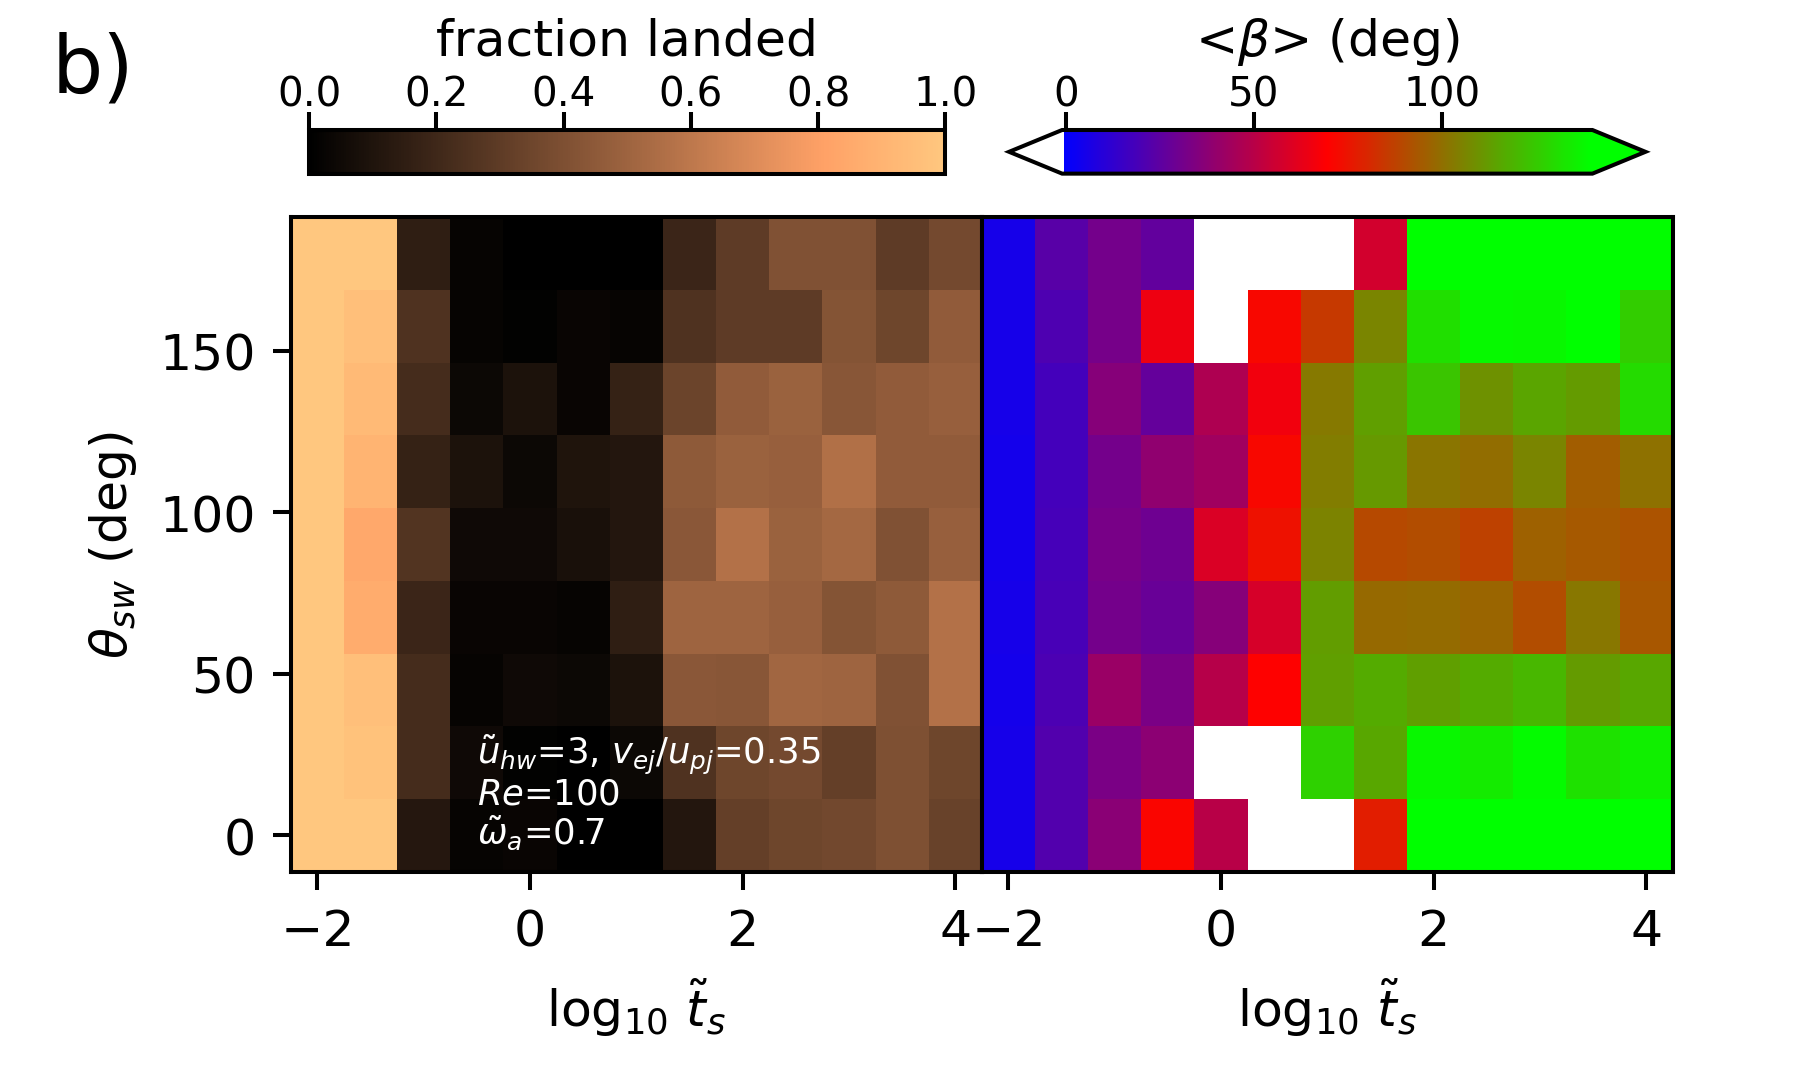

In [342]:
fig,axarr = plt.subplots(1,2,figsize=(5,3),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.16,right=0.92,top=0.80,bottom=0.2,hspace=0,wspace=0)
axarr[0].set_xlabel(r'log$_{10}$ $\tilde t_s$')
axarr[1].set_xlabel(r'log$_{10}$ $\tilde t_s$')
axarr[0].set_ylabel(r'$\theta_{sw}$ (deg)')
axarr[1].set_yticks([])
cax1 = plt.axes((0.17, 0.84, 0.35, 0.04))
cax1.tick_params(labelsize=8,pad=-0.5)
cax2 = plt.axes((0.555, 0.84, 0.35, 0.04))
cax2.tick_params(labelsize=8,pad=-0.5)

im=axarr[0].pcolormesh(lt_e, theta_2D_e*180/np.pi,1-nesc_2D_e,shading='auto',cmap='copper',vmin=0,vmax=1)
cbar = plt.colorbar(im,cax = cax1, location='top')
cbar.set_label(label='fraction landed',size=10)
im2=axarr[1].pcolormesh(lt_e, theta_2D_e*180/np.pi,mean_dt_e*180/np.pi,shading='auto',cmap=newcmp,vmin=-1,vmax=140) 
cbar2=plt.colorbar(im2,extend='both',extendfrac=0.1,cax = cax2, location='top')
cbar2.set_label(label=r'<$\beta$> (deg)',size=10)

xll = -0.5
dz = 12; y0=1.1
lcolor='white'
axarr[0].text(xll,y0, r'$\tilde \omega_{a}$=0.7',va='center',ha='left',fontsize=7,color=lcolor)
axarr[0].text(xll,y0+dz*1, r'$Re$=100',va='center',ha='left',fontsize=7,color=lcolor)
axarr[0].text(xll,y0+dz*2, r'$\tilde u_{hw}$=3, $v_{ej}/u_{pj}$=0.35',va='center',ha='left',fontsize=7,color=lcolor)

axarr[0].text(-4.5,230,'b)',fontsize=16)
plt.savefig('vesc_2D_thsw.png',dpi=200)


In [358]:
#parameter sweep ts and spin omega
ts_arr = np.logspace(-2,4.0,13)  # stopping times (dimensionless)
om_arr = np.linspace(0.2,1.02,10)
print(om_arr,ts_arr)

Re = 100  # Reynold number of whole body
theta_s_deg = 45.  # in degrees 
theta_s = theta_s_deg*np.pi/180.0   # in radians 

dt = 0.01  # timestep
nc = 100   # number of particles integrated 

vmax_fac =C_1*1.2**(-1/mu)
vmax_vmin_ratio = 1.0001
tilde_uhw = 1.4  # hardset

ts_2D,om_2D_d = np.meshgrid(ts_arr,om_arr)  # X,Y
lt_d = np.log10(ts_2D)
#lu_b = np.log10(om_2D)
nesc_2D_d = om_2D_d*0.0
mean_dt_d = om_2D_d*0.0
for j in range(len(ts_arr)):
    print(j)
    for i in range(len(om_arr)):
        tilde_Omega_a = om_2D_d[i,j]
        tilde_ts = ts_2D[i,j]
        print('ts,Om',tilde_ts,tilde_Omega_a)
        tilde_Omega_a_vec = np.array([np.sin(theta_s), 0.0, np.cos(theta_s)]) *tilde_Omega_a
        vmax = vmax_fac*tilde_uhw
        dtheta_arr, nesc,theta_init_arr,theta_final_arr = \
            stats2(nc,tilde_Omega_a_vec,vmax,vmax_vmin_ratio,tilde_ts,tilde_uhw,Re,dt)
        nesc_2D_d[i,j] = nesc/nc
        kk = (dtheta_arr >= 0)  # is Boolean
        nk = len(dtheta_arr[kk])
        if (nk>1):
            mean_dt_d[i,j] = np.mean(dtheta_arr[kk])
        else:
            mean_dt_d[i,j] = -100  # false value here

[0.2        0.29111111 0.38222222 0.47333333 0.56444444 0.65555556
 0.74666667 0.83777778 0.92888889 1.02      ] [1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00 3.16227766e+00 1.00000000e+01 3.16227766e+01
 1.00000000e+02 3.16227766e+02 1.00000000e+03 3.16227766e+03
 1.00000000e+04]
0
ts,Om 0.01 0.2
ts,Om 0.01 0.2911111111111111
ts,Om 0.01 0.38222222222222224
ts,Om 0.01 0.47333333333333333
ts,Om 0.01 0.5644444444444445
ts,Om 0.01 0.6555555555555557
ts,Om 0.01 0.7466666666666666
ts,Om 0.01 0.8377777777777777
ts,Om 0.01 0.9288888888888889
ts,Om 0.01 1.02
1
ts,Om 0.03162277660168379 0.2
ts,Om 0.03162277660168379 0.2911111111111111
ts,Om 0.03162277660168379 0.38222222222222224
ts,Om 0.03162277660168379 0.47333333333333333
ts,Om 0.03162277660168379 0.5644444444444445
ts,Om 0.03162277660168379 0.6555555555555557
ts,Om 0.03162277660168379 0.7466666666666666
ts,Om 0.03162277660168379 0.8377777777777777
ts,Om 0.03162277660168379 0.9288888888888889
ts,Om 0.0316227766

<IPython.core.display.Javascript object>


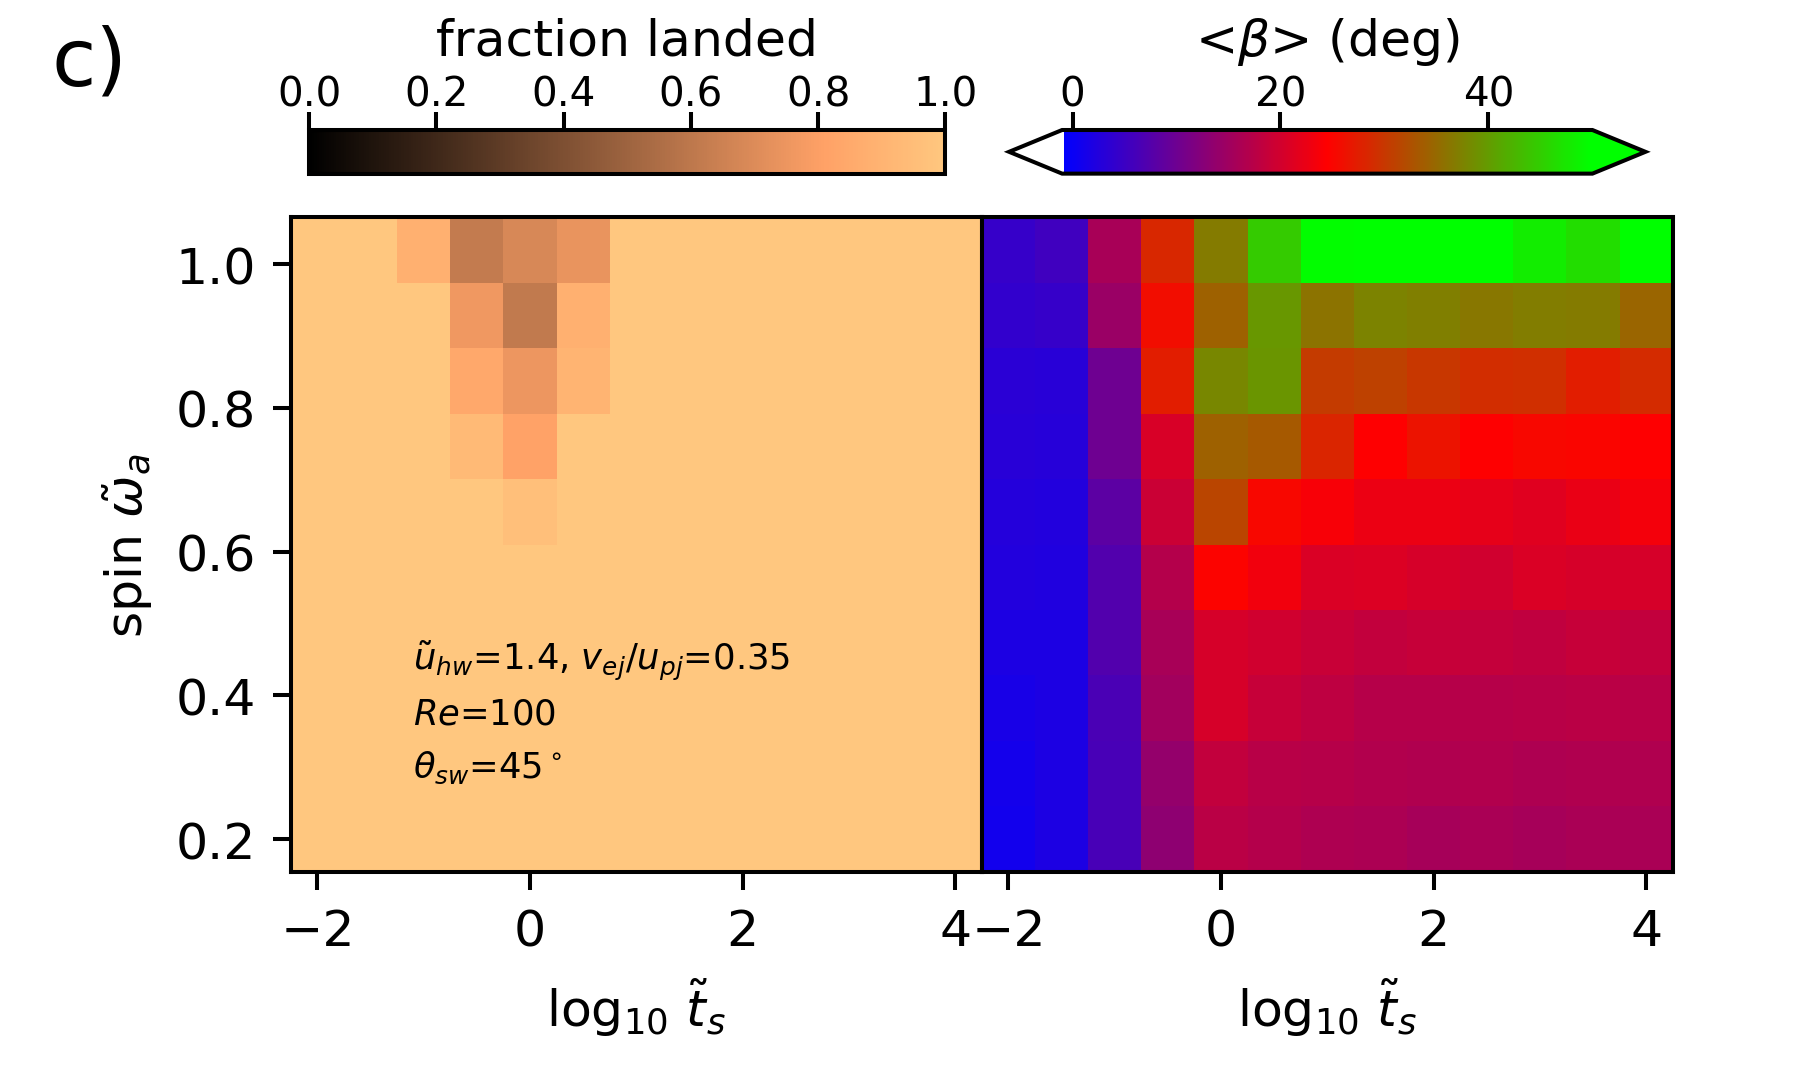

In [362]:
fig,axarr = plt.subplots(1,2,figsize=(5,3),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.16,right=0.92,top=0.80,bottom=0.2,hspace=0,wspace=0)
axarr[0].set_xlabel(r'log$_{10}$ $\tilde t_s$')
axarr[1].set_xlabel(r'log$_{10}$ $\tilde t_s$')
axarr[0].set_ylabel(r'spin $\tilde \omega_a$',labelpad=4)
axarr[1].set_yticks([])
cax1 = plt.axes((0.17, 0.84, 0.35, 0.04))
cax1.tick_params(labelsize=8,pad=-0.5)
cax2 = plt.axes((0.555, 0.84, 0.35, 0.04))
cax2.tick_params(labelsize=8,pad=-0.5)

im=axarr[0].pcolormesh(lt_d, om_2D_d,1-nesc_2D_d,shading='auto',cmap='copper',vmin=0,vmax=1)
cbar = plt.colorbar(im,cax = cax1, location='top')
cbar.set_label(label='fraction landed',size=10)
im2=axarr[1].pcolormesh(lt_d, om_2D_d,mean_dt_d*180/np.pi,shading='auto',cmap=newcmp,vmin=-1,vmax=50) 
cbar2=plt.colorbar(im2,extend='both',extendfrac=0.1,cax = cax2, location='top')
cbar2.set_label(label=r'<$\beta$> (deg)',size=10)

xll = -1.1
dz = 0.075; y0=0.3
lcolor='black'
axarr[0].text(xll,y0, r'$\theta_{sw}$=$45^\circ$',va='center',ha='left',fontsize=7,color=lcolor)
axarr[0].text(xll,y0+dz*1, r'$Re$=100',va='center',ha='left',fontsize=7,color=lcolor)
axarr[0].text(xll,y0+dz*2, r'$\tilde u_{hw}$=1.4, $v_{ej}/u_{pj}$=0.35',\
              va='center',ha='left',fontsize=7,color=lcolor)

axarr[0].text(-4.5,1.25,'c)',fontsize=16)
plt.savefig('vesc_2D_ws2.png',dpi=200)


In [345]:
#parameter sweep ts and spin angle 
ts_arr = np.logspace(-2,4.0,13)  # stopping times (dimensionless)
theta_arr = np.linspace(0.0,np.pi,9)
print(theta_arr,ts_arr)

Re = 100  # Reynold number of whole body
#theta_s_deg = 45.  # in degrees 
#theta_s = theta_s_deg*np.pi/180.0   # in radians 

dt = 0.005  # timestep
nc = 100   # number of particles integrated 
tilde_Omega_a=0.7

vmax_fac =C_1*1.2**(-1/mu)
vmax_vmin_ratio = 1.0001
tilde_uhw = 1.4  # hardset

ts_2D,theta_2D = np.meshgrid(ts_arr,theta_arr)  # X,Y
lt_f = np.log10(ts_2D)
nesc_2D_f = theta_2D*0.0
mean_dt_f = theta_2D*0.0
theta_2D_f = theta_2D
for j in range(len(ts_arr)):
    print(j)
    for i in range(len(theta_arr)):
        theta_s = theta_2D[i,j]
        tilde_ts = ts_2D[i,j]
        print('ts,theta_s',tilde_ts,theta_s)
        tilde_Omega_a_vec = np.array([np.sin(theta_s), 0.0, np.cos(theta_s)]) *tilde_Omega_a
        vmax = vmax_fac*tilde_uhw
        dtheta_arr, nesc,theta_init_arr,theta_final_arr = \
            stats2(nc,tilde_Omega_a_vec,vmax,vmax_vmin_ratio,tilde_ts,tilde_uhw,Re,dt)
        nesc_2D_f[i,j] = nesc/nc
        kk = (dtheta_arr >= 0)  # is Boolean
        nk = len(dtheta_arr[kk])
        if (nk>1):
            mean_dt_f[i,j] = np.mean(dtheta_arr[kk])
        else:
            mean_dt_f[i,j] = -100  # false value here

[0.         0.39269908 0.78539816 1.17809725 1.57079633 1.96349541
 2.35619449 2.74889357 3.14159265] [1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00 3.16227766e+00 1.00000000e+01 3.16227766e+01
 1.00000000e+02 3.16227766e+02 1.00000000e+03 3.16227766e+03
 1.00000000e+04]
0
ts,theta_s 0.01 0.0
ts,theta_s 0.01 0.39269908169872414
ts,theta_s 0.01 0.7853981633974483
ts,theta_s 0.01 1.1780972450961724
ts,theta_s 0.01 1.5707963267948966
ts,theta_s 0.01 1.9634954084936207
ts,theta_s 0.01 2.356194490192345
ts,theta_s 0.01 2.748893571891069
ts,theta_s 0.01 3.141592653589793
1
ts,theta_s 0.03162277660168379 0.0
ts,theta_s 0.03162277660168379 0.39269908169872414
ts,theta_s 0.03162277660168379 0.7853981633974483
ts,theta_s 0.03162277660168379 1.1780972450961724
ts,theta_s 0.03162277660168379 1.5707963267948966
ts,theta_s 0.03162277660168379 1.9634954084936207
ts,theta_s 0.03162277660168379 2.356194490192345
ts,theta_s 0.03162277660168379 2.748893571891069
ts,theta_s 0

<IPython.core.display.Javascript object>


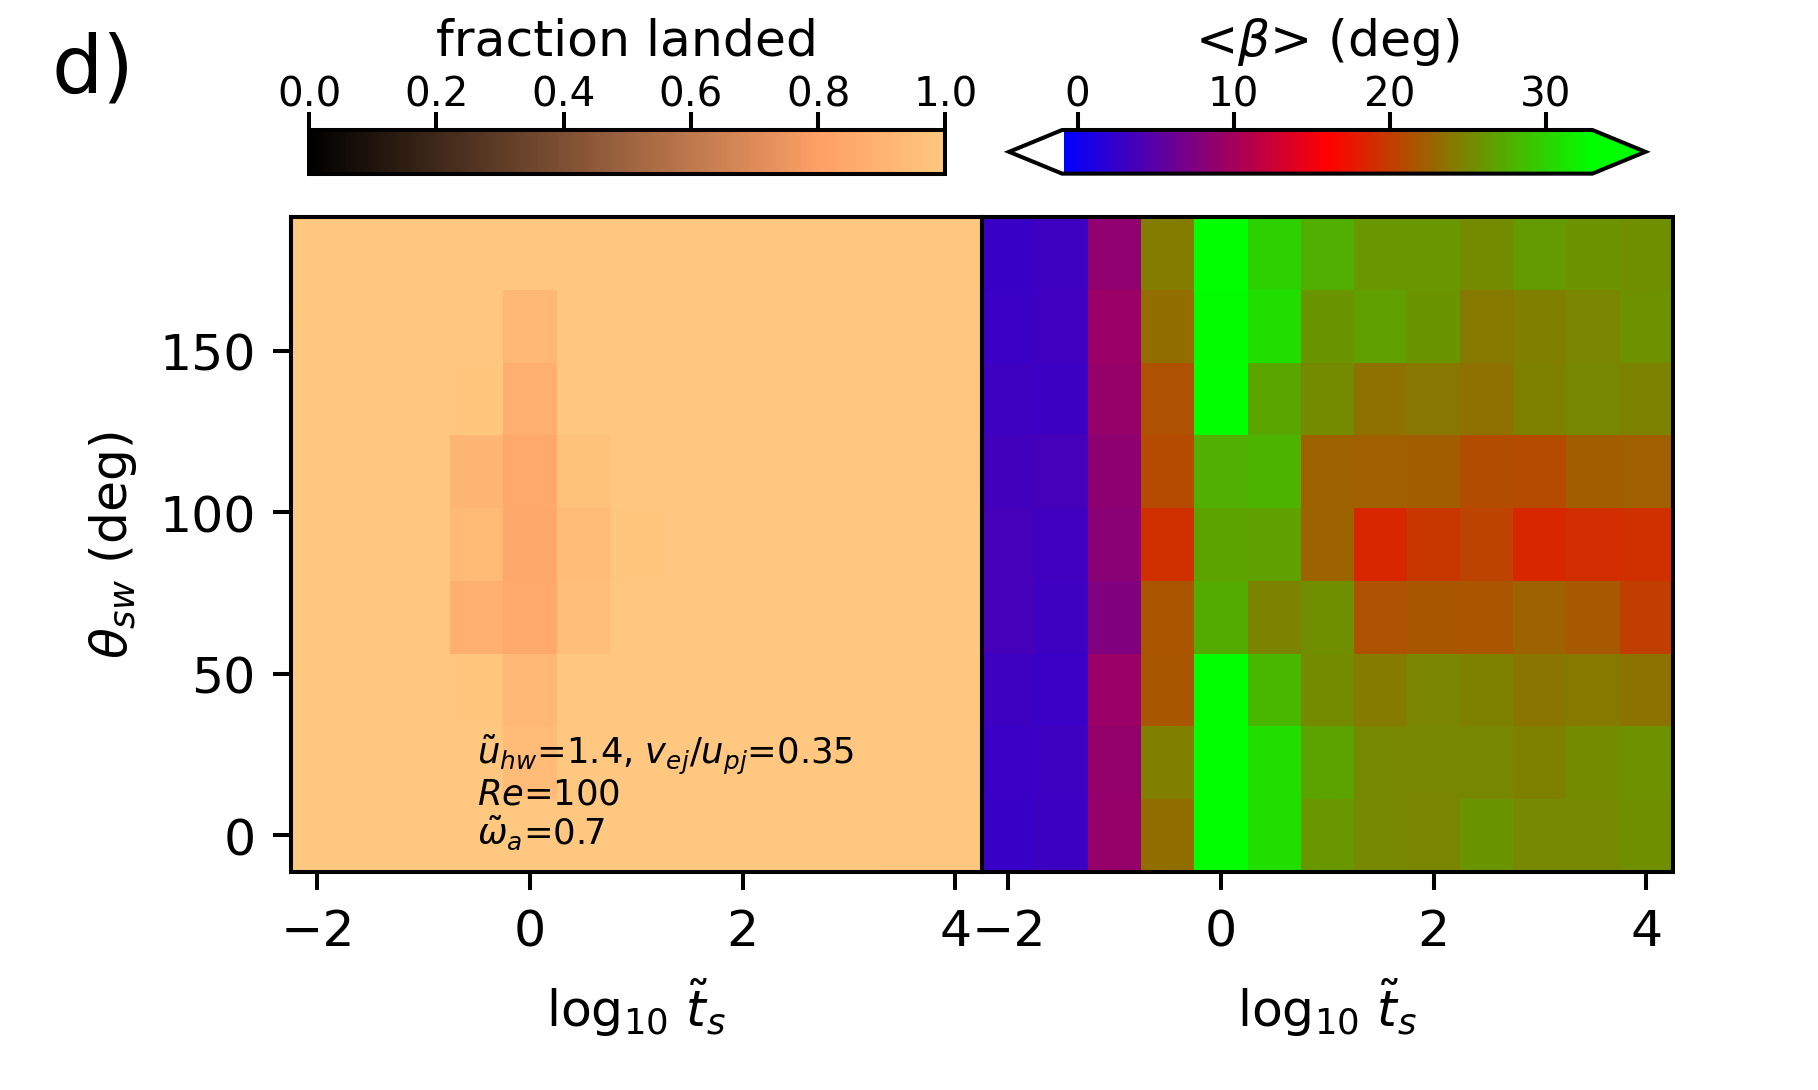

In [370]:
fig,axarr = plt.subplots(1,2,figsize=(5,3),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.16,right=0.92,top=0.80,bottom=0.2,hspace=0,wspace=0)
axarr[0].set_xlabel(r'log$_{10}$ $\tilde t_s$')
axarr[1].set_xlabel(r'log$_{10}$ $\tilde t_s$')
axarr[0].set_ylabel(r'$\theta_{sw}$ (deg)')
axarr[1].set_yticks([])
cax1 = plt.axes((0.17, 0.84, 0.35, 0.04))
cax1.tick_params(labelsize=8,pad=-0.5)
cax2 = plt.axes((0.555, 0.84, 0.35, 0.04))
cax2.tick_params(labelsize=8,pad=-0.5)

im=axarr[0].pcolormesh(lt_f, theta_2D_f*180/np.pi,1-nesc_2D_f,shading='auto',cmap='copper',vmin=0,vmax=1)
cbar = plt.colorbar(im,cax = cax1, location='top')
cbar.set_label(label='fraction landed',size=10)

im2=axarr[1].pcolormesh(lt_f, theta_2D_f*180/np.pi,mean_dt_f*180/np.pi,shading='auto',cmap=newcmp,vmin=-1,vmax=33) 
cbar2=plt.colorbar(im2,extend='both',extendfrac=0.1,cax = cax2, location='top')
cbar2.set_label(label=r'<$\beta$> (deg)',size=10)

xll = -0.5
dz = 12; y0=1.1
lcolor='black'
axarr[0].text(xll,y0, r'$\tilde \omega_{a}$=0.7',va='center',ha='left',fontsize=7,color=lcolor)
axarr[0].text(xll,y0+dz*1, r'$Re$=100',va='center',ha='left',fontsize=7,color=lcolor)
axarr[0].text(xll,y0+dz*2, r'$\tilde u_{hw}$=1.4, $v_{ej}/u_{pj}$=0.35',va='center',ha='left',fontsize=7,color=lcolor)

axarr[0].text(-4.5,230,'d)',fontsize=16)
plt.savefig('vesc_2D_thsw2.png',dpi=200)
